# BAT TTE Analysis Overview

## This notebook gives a brief overview of the capabilities of the BatAnalysis package to dynamically analyze BAT Time-tagged Event (TTE) data. 

## Installation instructions for Beta testers:

Thanks to all who are willing to test the TTE portion of BatAnalysis. Here are some quick instructions for getting the code and installing it for access in python:
- `git clone -b TTE_analysis https://github.com/parsotat/BatAnalysis.git`
- `cd BatAnalysis`
- if BatAnalysis is already installed: `pip uninstall BatAnalysis`
- `pip install -e .`

Then in a jupyter notebook or an ipython session `import batanalysis as ba` should work.

Any issues that get brought up will be pushed to the github branch. To get these changes simply do `git pull` in the BatAnalysis directory and the next time you do `import batanalysis as ba` the changes will be implemented.

Here, we will analyze a BAT triggered GRB to exhibit the various capabilities that the BatAnalysis tool offers to interact with the TTE data, allowing users to download data, create lightcurves which can be dynamically rebinned in time and energy, and also create Pulse Height Amplitude (PHA) files for any arbitrary time bin at arbitrary energy binning. 

First, we will look at GRB 211211A, a bright long GRB that was determined to be from a merger of compact objects. This GRB was detected by BAT and the refined analyses can be found here: https://swift.gsfc.nasa.gov/results/batgrbcat/GRB211211A/web/GRB211211A.html

Lets start off by importing the necessary python packages. 

In [1]:
import xspec
import batanalysis as ba
import swiftbat
from swifttools.swift_too import ObsQuery 

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from pathlib import Path
from astropy.io import fits
from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import SkyCoord
import datetime
import os

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### 1. Download the data

First, lets look at downloading the BAT TTE data for this event. We will use the basics of downloading Swift BAT data covered in the **Example_data_download** notebook in this directory. 

We will use the swifttools package to query over the hour that the GRB has occured to get the observations that have occured. We expect the GRB to appear here since we know that the GRB occured on 2021-12-11 with the trigger time of 13:09:59.634260 UTC. 

Documentation for swifttools can be found here: https://www.swift.psu.edu/too_api/


In [2]:
#%matplotlib widget

tstart=Time("2021-12-11T13:00:00")
tend=Time("2021-12-11T14:00:00")

obs_table=ObsQuery(begin=tstart, end=tend)
print(obs_table)

+---------------------+---------------------+----------------------+--------------------+--------------+--------------+
|          Begin Time |            End Time |          Target Name | Observation Number | Exposure (s) | Slewtime (s) |
+---------------------+---------------------+----------------------+--------------------+--------------+--------------+
| 2021-12-11 12:57:02 | 2021-12-11 13:10:36 |              Mrk 279 |        00037591121 |          685 |          129 |
| 2021-12-11 13:10:37 | 2021-12-11 13:15:21 |          GRB 211211A |        01088940000 |          215 |           69 |
| 2021-12-11 13:15:26 | 2021-12-11 13:28:00 |        CYGNUSCOCOON2 |        00095933007 |          630 |          124 |
| 2021-12-11 13:28:02 | 2021-12-11 13:52:57 | XMM_J004855.5-734946 |        00034599017 |         1310 |          185 |
| 2021-12-11 13:53:02 | 2021-12-11 13:57:59 |           SN2021aefx |        00014916016 |          235 |           62 |
| 2021-12-11 13:58:03 | 2021-12-11 14:06

We have found the observation! Lets programatically select this observation and download all the data in the bat and auxil directories to a temporary directory. 

In [3]:
always_use_tmp=True
tmp_download_dir="/tmp/batdata/download_examples"

ba.datadir(tmp_download_dir, mkdir=True)

grb_obs=[i for i in obs_table if "GRB" in i.targname]
download = ba.download_swiftdata(grb_obs, quiet=True)
print(download)

{'01088940000': {'obsid': '01088940000', 'success': True, 'obsoutdir': PosixPath('/private/tmp/batdata/download_examples/01088940000'), 'quicklook': False, 'data': Swift_Data(username='anonymous',obsid='01088940000',quicklook='False',auxil='True',bat='True',xrt='False',uvot='False',log='False',tdrss='True')}}


Lets take a look at the files that we have downloaded. 

In [4]:
download[grb_obs[0].obsid]["data"]

01088940000/auxil,SWIFT_TLE_ARCHIVE.txt.21353.74897066.gz,Auxillary TLE file
'',sw01088940000pat.fits.gz,Auxillary attitude file
'',sw01088940000pjb.par.gz,Auxillary file
'',sw01088940000pob.cat.gz,Auxillary catalog
'',sw01088940000ppr.par.gz,Auxillary file
'',sw01088940000s.mkf.gz,Auxillary file
'',sw01088940000sao.fits.gz,Auxillary file
'',sw01088940000sat.fits.gz,Auxillary attitude file
'',sw01088940000sen.hk.gz,Auxillary housekeeping
'',sw01088940000sti.fits.gz,Auxillary file
'',sw01088940000uat.fits.gz,Auxillary attitude file


As is shown above, we have: 
 - the auxil directory with information related to the spacecraft, 
 - the tdrss directory with information related to the tdrss downlinked information for the GRB when it triggered BAT, 
 - the rate directory which holds hardware rate information, 
 - the event directory with the TTE data
 - the housekeeping directory with information related to the BAT instrument itself
 - the masktag directory with the Swift Data Center (SDC) precomputed coded mask weights for the GRB
 - the products directory with SDC precomputed lightcurves at various time/energy binnings, pha files at predetermined timebins, and sky images
 - the survey directory which holds BAT survey data associated with this observation, which can be analyzed following the **Example_Survey_Data_Analysis** notebook
 
 We will show how we can interact and reproduce the precomputed data files from the SDC, and how we can construct new lightcurves/pha files and access the relevant data.

### 2. Loading the raw rates lightcurve

Sometimes, a source can be evident just by looking at the raw rates lightcurve without any mask weighting. Lets use the BatAnalysis Lightcurve object to load one of these raw lightcurve files and plot it as out first step in our analysis. For this we will call the `from_file()` class function as is shown below:

In [5]:
datadir=ba.datadir().joinpath(grb_obs[0].obsid)
raw_lc=ba.Lightcurve.from_file(datadir.joinpath("bat/rate").joinpath("sw01088940000brtqd.lc.gz"))

/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/batproducts.py:1213: UserWarning: No event file has been specified. The resulting lightcurve object will not be able to be modified either by rebinning in energy or time.
/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/batproducts.py:1213: UserWarning: No detector quality mask file has been specified. The resulting lightcurve object will not be able to be modified either by rebinning in energy or time.


Note that we have just loaded the quad rates file which gives out counts that are is prebinned into 1.6 second timebins with 4 predetermined energy bins used in teh on-board triggering algorithm (15-25, 25-50, 50-100,100-350 keV), for each quadrant of the BAT detector plane (more info can be found here: https://swift.gsfc.nasa.gov/analysis/bat_swguide_v6_3.pdf). We also get a warning stating that we will not be able to change this energy/time binning which is fine for loading this rate file. 

Next, lets plot this raw quad rates lightcurve:

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: ylabel='Q0 COUNTS (ct)'>, <Axes: ylabel='Q1 COUNTS (ct)'>,
        <Axes: ylabel='Q2 COUNTS (ct)'>,
        <Axes: xlabel='MET (s)', ylabel='Q3 COUNTS (ct)'>], dtype=object))

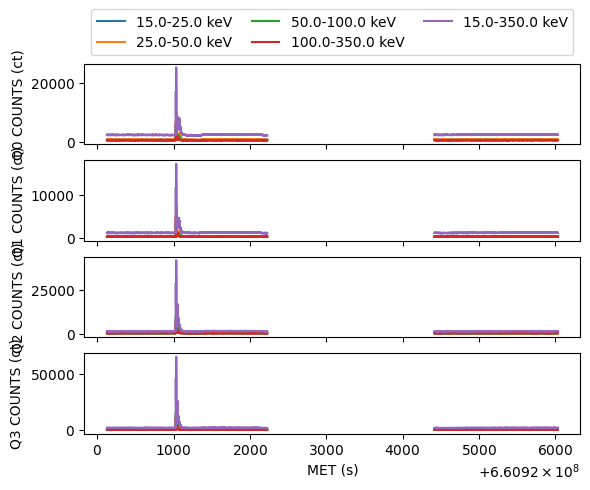

In [6]:
raw_lc.plot()

We can see firstly that the GRB is well seen in the raw lightcurve across the detector quadrants, where each quadrant is a different subplot. Furthermore, there are more than 4 energy ranges plotted. This is due to the fact that the Lightcurve object automatically calculated the energy integrated lightcurve based on the energy bins that are provided by default.  

Lets instead plot the lowest energy bin where there is typically noise in the detector, and see how strong this GRB may stand out against any detector noise.

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: ylabel='Q0 COUNTS (ct)'>, <Axes: ylabel='Q1 COUNTS (ct)'>,
        <Axes: ylabel='Q2 COUNTS (ct)'>,
        <Axes: xlabel='MET (s)', ylabel='Q3 COUNTS (ct)'>], dtype=object))

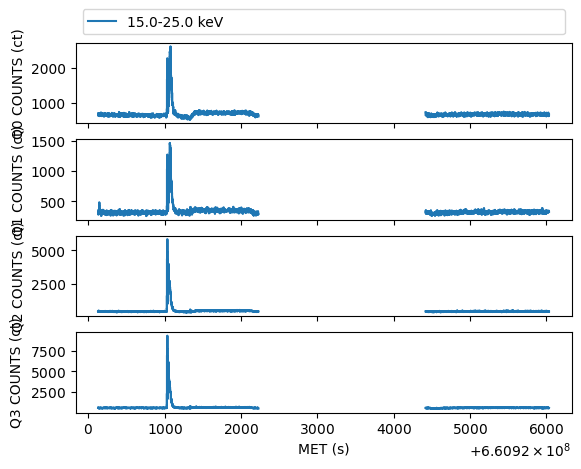

In [7]:
raw_lc.plot(energybins=[15,25]*u.keV)

### 3. Loading in preconstructed Lightcurves

We can also load in the prconstructed lightcurves from the SDC to take a look at them. Lets load in the 1 second binned mask weighted lightcurve and plot it alongside the total detector counts and the fractional exposure.

In [8]:
lc_1s=ba.Lightcurve.from_file(datadir.joinpath("bat/products").joinpath("sw01088940000bev1s.lc.gz"))

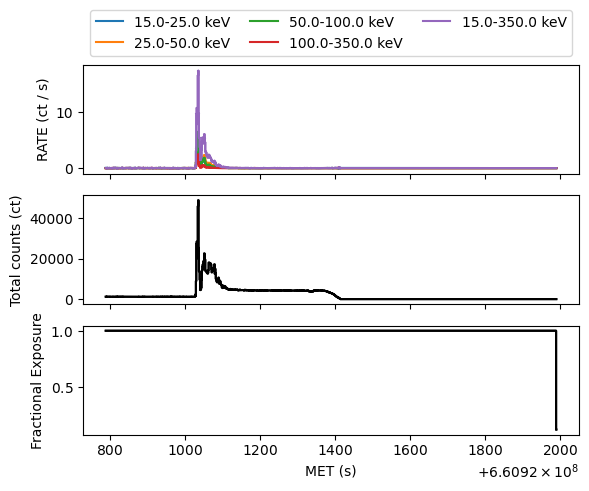

In [9]:
fig, ax=lc_1s.plot(plot_counts=True, plot_exposure_fraction=True)


We can access all the data in the lightcurve thorugh the `lc_1s` variable's data attribute. 

In [10]:
lc_1s.data

{'TIME': <Quantity [6.60920788e+08, 6.60920789e+08, 6.60920790e+08, ...,
            6.60921988e+08, 6.60921989e+08, 6.60921990e+08] s>,
 'RATE': <Quantity [[ 0.0229589 , -0.00310736, -0.00054422, -0.01433627,
              0.00497105],
            [ 0.00230726, -0.00093139,  0.00934972,  0.00646745,
              0.01719304],
            [-0.01685957, -0.02189074, -0.00260321, -0.01626634,
             -0.05761987],
            ...,
            [ 0.        ,  0.        ,  0.        ,  0.        ,
              0.        ],
            [ 0.        ,  0.        ,  0.        ,  0.        ,
              0.        ],
            [ 0.        ,  0.        ,  0.        ,  0.        ,
              0.        ]] ct / s>,
 'ERROR': <Quantity [[0.01380037, 0.0131629 , 0.0122548 , 0.01012912, 0.02482924],
            [0.01281852, 0.0133983 , 0.01199247, 0.01032697, 0.02437816],
            [0.01296971, 0.01374815, 0.0118413 , 0.01048451, 0.0246448 ],
            ...,
            [0.        , 0.  

The timebin start and stop times can be obtained through the tbins attribute and the energybin information can be obtained thorugh the ebins attribute


In [11]:
print(lc_1s.tbins)
print(lc_1s.ebins)

{'TIME_CENT': <Quantity [6.60920788e+08, 6.60920790e+08, 6.60920790e+08, ...,
           6.60921988e+08, 6.60921990e+08, 6.60921990e+08] s>, 'TIME_START': <Quantity [6.60920788e+08, 6.60920789e+08, 6.60920790e+08, ...,
           6.60921988e+08, 6.60921989e+08, 6.60921990e+08] s>, 'TIME_STOP': <Quantity [6.60920789e+08, 6.60920790e+08, 6.60920791e+08, ...,
           6.60921989e+08, 6.60921990e+08, 6.60921991e+08] s>}
{'INDEX': array([0, 1, 2, 3, 4], dtype=int16), 'E_MIN': <Quantity [ 15.,  25.,  50., 100.,  15.] keV>, 'E_MAX': <Quantity [ 25.,  50., 100., 350., 350.] keV>}


### 4. Loading in preconstructed PHA files

Similar to lightcurves, PHA files can be loaded, inspected, and even conveniently fit. All the data present in these files are also easily accessible to the user. This is possible with the Spectrum object.

Lets load in the pre-slew pha file computed by the SDC, which also ensures that the associated drm file is created. Note that the pha file gets unzipped as it is loaded in. This is necessary for xspec fitting in the next few cells.

/private/tmp/batdata/download_examples/01088940000/bat/products/sw01088940000bevps.rsp


/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/batproducts.py:2173: UserWarning: No event file has been specified. The resulting spectrum object will not be able to bemodified either by rebinning in energy or time.
/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/batproducts.py:2173: UserWarning: No detector quality mask file has been specified. The resulting spectrum object will not be able to be modified either by rebinning in energy or time.
/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/batproducts.py:2173: UserWarning: No auxiliary ray tracing file has been specified. The resulting spectrum object will not be able to be modified either by rebinning in energy or time.


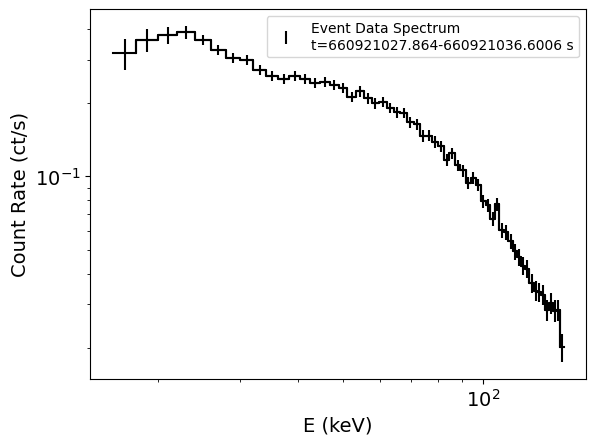

In [12]:
pha_ps=ba.Spectrum.from_file(datadir.joinpath("bat/products").joinpath("sw01088940000bevps.pha.gz"))
pha_ps.plot()
print(pha_ps.drm_file)

All the data can be accessed as:

In [13]:
print(pha_ps.data)
print(pha_ps.tbins)
print(pha_ps.ebins)

{'CHANNEL': <Quantity [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
           13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
           26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
           39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
           52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
           65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
           78., 79.]>, 'RATE': <Quantity [0.04396221, 0.10250551, 0.20537154, 0.27386412, 0.31859604,
           0.36155137, 0.37702068, 0.38736706, 0.3610995 , 0.32874151,
           0.30478462, 0.29806452, 0.27307312, 0.25759929, 0.24998268,
           0.25717661, 0.24987546, 0.24014129, 0.24209184, 0.23536998,
           0.22931243, 0.21181355, 0.22250997, 0.20842   , 0.19872025,
           0.20126084, 0.19066334, 0.18264604, 0.18172878, 0.16597786,
           0.1630109 , 0.14629033, 0.14684736, 0.13847703, 0.1329215 ,
    

With this information loaded as a Spectrum object, we can conveniently fit this with the `fit_spectrum` function of the BatAnalysis package. By default, this will fit a `cflux*powerlaw` xspec model to the spectrum from 15-150 keV. Lets try that and see how we can access the fitted spectral model parameters/information:


1 spectrum  in use
 
Spectral Data File: sw01088940000bevps.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.008e+01 +/- 2.803e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 8.737 sec
 Using fit statistic: chi
 Using Response (RMF) File            sw01088940000bevps.rsp for Source 1


Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   5    2   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared                     nan     using 80 bins

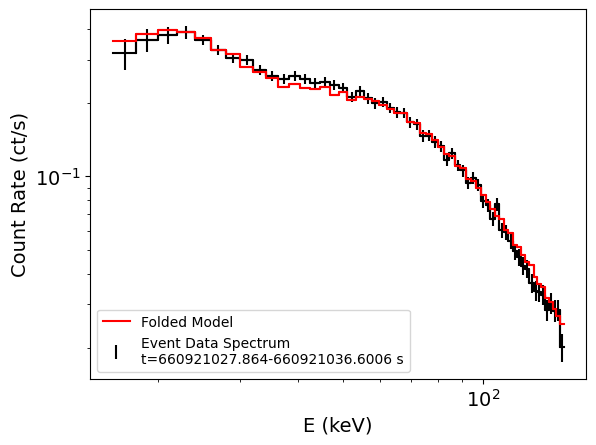

In [14]:
ba.fit_spectrum(pha_ps)

The function call automatically plots the results of the fit for us and that looks pretty good. To access the information related to the fit we can use the newly added spectral_model attribute to the Spectrum object. This contains all the information related to the fitted parameters of the model, the 1 $\sigma$ errors of those parameters, and all the folded model data such as the folded rates predicted by the model and the energy bins. If the use wants to access the xspec session that was used to conduct the fit, this can be done through the 'xspec_session' key with the saved session file (see xspec documentation for more info). 

In [15]:
pha_ps.spectral_model

{'parameters': {'Emin': {'val': 15.0,
   'lolim': 0.0,
   'hilim': 0.0,
   'errflag': 'FFFFFTFFF'},
  'Emax': {'val': 150.0, 'lolim': 0.0, 'hilim': 0.0, 'errflag': 'FFFFFTFFF'},
  'lg10Flux': {'val': -5.145277776193761,
   'lolim': -5.236799645567957,
   'hilim': -5.05777292908673,
   'errflag': 'FFFFFFFFF'},
  'PhoIndex': {'val': 1.1450225316585505,
   'lolim': 0.8300699935670177,
   'hilim': 1.4586103110931021,
   'errflag': 'FFFFFFFFF'},
  'norm': {'val': 0.001, 'lolim': 0.0, 'hilim': 0.0, 'errflag': 'FFFFFTFFF'}},
 'data': {'model_spectrum': <Quantity [0.35673152, 0.38125678, 0.3942963 , 0.38968377, 0.36656635,
             0.32955698, 0.31679695, 0.27859889, 0.26691423, 0.25136642,
             0.23261707, 0.23757527, 0.23019573, 0.22638367, 0.23193557,
             0.21526879, 0.22085775, 0.20570901, 0.21166618, 0.20716101,
             0.20246221, 0.19492374, 0.18838679, 0.18118037, 0.18177562,
             0.16673561, 0.16578346, 0.15038204, 0.14878477, 0.14052132,
            

We can conduct a simple calculation to determine if the GRB is significantly detected as well. Similar to the BAT survey analysis pipeline, this function determines if the source is detected to some significance level (3$\sigma$ by default), and if it is not creates an upper limit spectrum based on the background variation, allowing for the estimation of a flux upper limit (at the 5$\sigma$ level by default).

In [16]:
output_spectrum=ba.calculate_detection(pha_ps, pl_index=1, plotting=True)

The condition here is 7.156855089612179e-06 [5.796960677490505e-06, 8.754413802007447e-06] 3 1.4787265622584708e-06 2.7206754028367665e-06
A detection has been measured at the 3 sigma level


Since the GRB has been measured to the $3\sigma$ level, the returned spectrum is the same as what is passed into the function. If there was not a significant detection, the returned spectrum will be the upper limit calculated spectrum.

### 4. Loading/Processing the TTE observation data

To create our own data products, we need to first create a BatEvent object by passing in the observation ID that we just downloaded. (Since we initalized the ba.datadir(), the program knows where to automatically look for the data that we just downloaded). Thsi copies over any relevant files to a new directory which will hold the files necessary for our analysis and any custom data products we create. We set `recalc=True` so everytime a user runs this notebook they start fresh and dont inadvertently load modified files from the `*_eventresult` directory. 

In [17]:
event=ba.BatEvent(grb_obs[0].obsid, recalc=True)

A save file has been written to /private/tmp/batdata/download_examples/01088940000_eventresult/batevent.pickle.


This ensures that a number of calibrations have been taken care of, loads any necessary information, and creates any necessary files that may be missing. By default, the coordinates of the triggered GRB (found in the TDRSS messages) are loaded and used to create mask weights and auxiliary raytracing files which are needed to produce lightcurves and PHA files. The BatEvent object is then saved, which allows for convenient reloading of an analysis, similar to the survey analysis capabilities.

Lets take a look at the `event` variable and the information that it holds. Firstly, we can identify the various necessary files for general TTE analyses:

In [18]:
print(event.event_files)
print(event.attitude_file)
print(event.auxil_raytracing_file)
print(event.detector_quality_file)
print(event.gain_offset_file)

/private/tmp/batdata/download_examples/01088940000_eventresult/events/sw01088940000bevshsp_uf.evt
/private/tmp/batdata/download_examples/01088940000_eventresult/auxil/sw01088940000sat.fits.gz
/private/tmp/batdata/download_examples/01088940000_eventresult/events/sw01088940000bevtr.fits.gz
/private/tmp/batdata/download_examples/01088940000_eventresult/auxil/sw01088940000bdqcb.hk.gz
/private/tmp/batdata/download_examples/01088940000_eventresult/auxil/sw01088940000bgocb.hk.gz


We can also take a look at the data that gets loaded thorugh the data attribute:

In [19]:
event.data

{'TIME': <Quantity [6.60920788e+08, 6.60920788e+08, 6.60920788e+08, ...,
            6.60921990e+08, 6.60921990e+08, 6.60921990e+08] s>,
 'DET_ID': <Quantity [ 1495., 28445.,  7364., ...,  6848., 31065., 31118.]>,
 'EVENT_FLAGS': <Quantity [0., 0., 0., ..., 0., 0., 0.]>,
 'PHA': <Quantity [2706., 2531., 2659., ..., 2111., 2088.,  592.] chan>,
 'MASK_WEIGHT': <Quantity [0., 0., 0., ..., 0., 0., 0.]>,
 'DETX': <Quantity [ 23., 183., 133., ..., 115., 281., 271.] pix>,
 'DETY': <Quantity [150.,  82., 169., ..., 121.,  39.,  28.] pix>,
 'PI': <Quantity [   252.,    464.,    298., ...,   1336.,   1331., -32768.] chan>,
 'ENERGY': <Quantity [   25.2,    46.4,    29.8, ...,   133.6,   133.1, -3276.8] keV>}

We have the time of each detected photon, the location of the detector that measured the photon, the mask weight of the event assuming the TDRSS coordinates, the pulse height amplitude, the pulse invariant measurement, and the energy of the photon which is calculated using the gain/offset calibration information.


If we want to know what the ra/dec of the point that was used to calculated the mask weights we simply access those attributes:

In [20]:
print(event.ra, event.dec)

212.2912 27.88998


These coordinates are slightly different than those where the afterglow was discovered (GCN 31203)[https://gcn.nasa.gov/circulars/31203?query=211211A&startDate=&endDate=]

In [21]:
afterglow_coords=SkyCoord(ra="14h09m10.09s",dec="27d53m18.23s")
print(afterglow_coords.ra.deg, afterglow_coords.dec.deg)

212.29204166666665 27.88839722222222


Lets refine the position of our mask weights with the refined position and compare it to what is in the event file:

In [22]:
old_weights=event.data["MASK_WEIGHT"]
old_coords=SkyCoord(event.ra, event.dec, unit="deg")

#recalculate the mask weights
event.apply_mask_weighting(ra=afterglow_coords.ra.deg, dec=afterglow_coords.dec.deg)

212.29204166666665 27.88839722222222


/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide


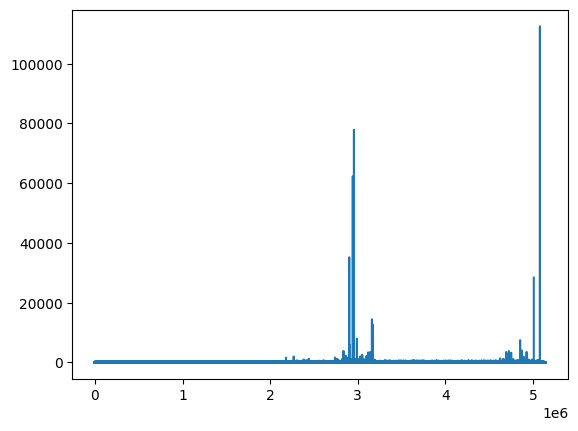

In [23]:
#compare the new and old coordinates
print(event.ra, event.dec)

#compare the difference in weights
fig,ax=plt.subplots()
ax.plot(np.abs((old_weights-event.data["MASK_WEIGHT"])/old_weights))


# An important thing to note is that the event file MASK_WEIGHT column was modified by the apply_mask_weighting method and the file was reloaded into the event variable's data attribute. 

# It is important to verify that the mask weight that is loaded corresponds to the source that you want to analyze before moving forward with creating lightcurves and spectra. 

# This is especially relevant as users can resume from a previous TTE data analysis session and should be sure that they know what the ra/dec attributes are before they produce erroneous lightcurves and spectra.

### 5. Creating a custom lightcurve

Lets create a custom lightcurve now using 1 second time binning. And plot the lightcurve. We expect this to look like the precomputed lightcurve that was loaded before (although there will be minor differences in the mask weighting due to the different RA/Dec coordinates used)

In [24]:
event.create_lightcurve(timedelta=np.timedelta64(1, "s"))

The new 1 sec lightcurve has coordinates: 212.2920416666666, 27.88839722222222
The precalculated mask weighted lightcurve was constructed with Ra/Dec: 212.2912,27.88998


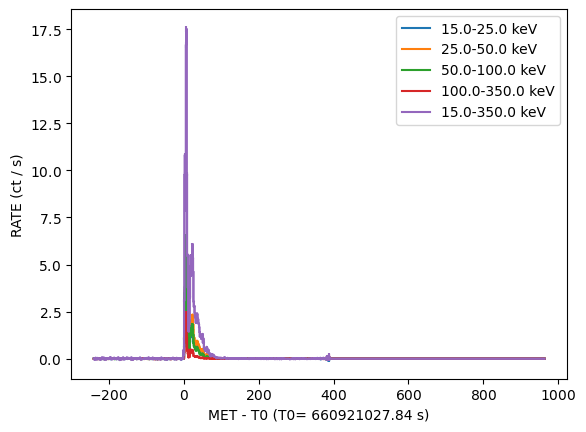

In [25]:
event.lightcurve.plot(T0=event.trigtime_met, plot_relative=True)
event.lightcurve.lightcurve_file
print(f"The new 1 sec lightcurve has coordinates: {event.lightcurve.ra}, {event.lightcurve.dec}")
print(f"The precalculated mask weighted lightcurve was constructed with Ra/Dec: {lc_1s.ra},{lc_1s.dec}")

The lightcurve information is both saved to the event's `lightcurve` attribute, which holds information related to the most recently calculated lightcurve, and is returned as a Lightcurve object that the user can save explicitly. We can save the event anlaysis by calling `event.save()` and the created lightcurve and all the information will also be saved, allowing the user to pick up their analysis from a similar point as before.

Lets change the energy and time binnings now. We will use bayesian binning, which will also give us our measured durations such as T90, T50, etc. (see the documentation for battblocks), and also set the energybin to be from 30-190 keV. 

T90 is estimated as: 51.13599991798401 s


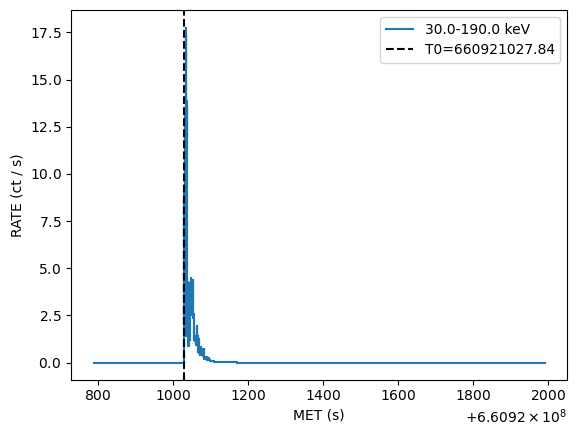

In [26]:
event.lightcurve.set_timebins(timebinalg="bayesian")
event.lightcurve.set_energybins(emin=30*u.keV, emax=190*u.keV)
event.lightcurve.plot(T0=event.trigtime_met)
print(f'T90 is estimated as: {event.lightcurve.tdurs["T90"]["TSTOP"]-event.lightcurve.tdurs["T90"]["TSTART"]}')

We can also set time bins relative to trigger time. Notice how the energy binning has not changed, just the time binning in the next cell.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='MET - T0 (T0= 660921027.84 s)', ylabel='RATE (ct / s)'>)

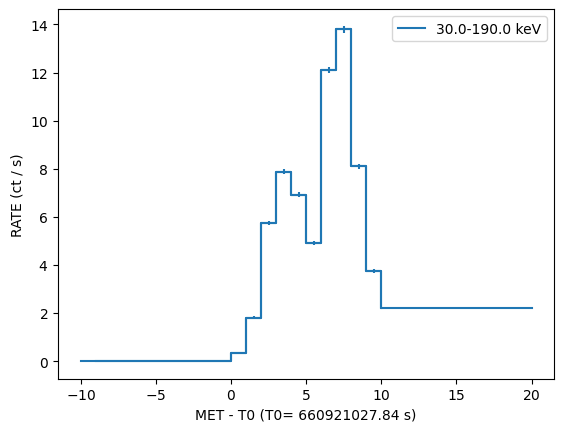

In [27]:
custom_timebins=[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1,2,3,4,5,6,7,8,9, 10, 20]*u.s
event.lightcurve.set_timebins(timebins=custom_timebins, is_relative=True, T0=event.trigtime_met)
event.lightcurve.plot(T0=event.trigtime_met, plot_relative=True)

### 6. Creating Custom PHA files

Similar to creating custom lightcurves, PHA files can also be created. Lets create one for the T90 period which we measured in the previous section and fit it with a powerlaw. 

First, we create the Spectrum, which gets saved to the spectrum attribute of the event variable.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='E (keV)', ylabel='Count Rate (ct/s)'>)

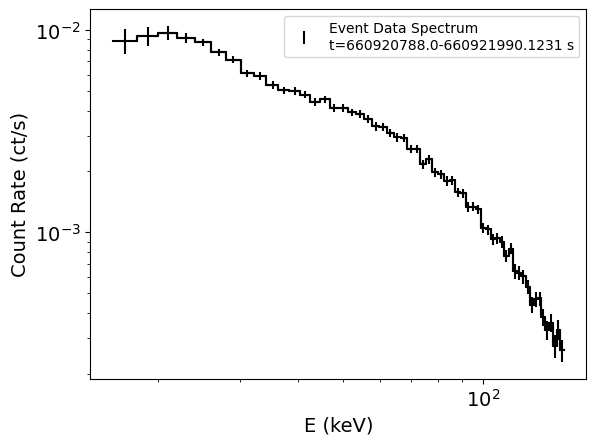

In [28]:
event.create_pha(tstart=event.lightcurve.tdurs["T90"]["TSTART"], tstop=event.lightcurve.tdurs["T90"]["TSTOP"])
event.spectrum.plot()

Lets now fit the spectrum and see what we get:


1 spectrum  in use
 
Spectral Data File: spectrum_0.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.978e-01 +/- 8.251e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1202 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_0.rsp for Source 1


Fit statistic  : C-Statistic                23737.44     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared              8.028318e+07     using 80 bins.
 Null hypothesis probability of 0.000000e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4 

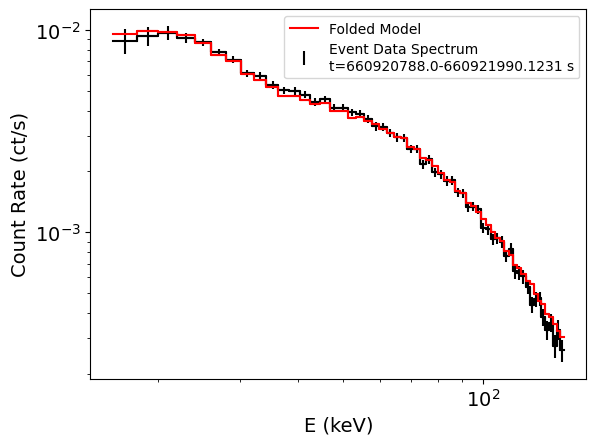

In [29]:
ba.fit_spectrum(event.spectrum)

We can also make time resolved spectra for each timebin in our custom binned lightcurve. We pass in the different timebins, specify the T0 that they are defined with respect to, and set `recalc=True` so we can create a new set of pha files and not load in the previously created T90 one a few cells back.

In [30]:
spectrum_list=event.create_pha(timebins=custom_timebins, T0=event.trigtime_met, is_relative=True, recalc=True)

/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/bat_tte.py:744: UserWarning: Deleting all files in /private/tmp/batdata/download_examples/01088940000_eventresult/pha and creating newpha files for the passed in timebins


We can verify that the spectra have the timebins that we expect them to have by printing their relative times. Lets also go ahead and plot them at the same time. We will see that some of the 1 second timebins dont really show the GRB as they just look like noise.

[-10.] s [-9.] s
[-9.] s [-8.] s
[-8.] s [-7.] s
[-7.] s [-6.] s
[-6.] s [-5.] s
[-5.] s [-4.] s
[-4.] s [-3.] s
[-3.] s [-2.] s
[-2.] s [-1.] s
[-1.] s [0.] s
[0.] s [1.] s
[1.] s [2.] s
[2.] s [3.] s
[3.] s [4.] s
[4.] s [5.] s
[5.] s [6.] s
[6.] s [7.] s
[7.] s [8.] s
[8.] s [9.] s
[9.] s [10.] s
[10.] s [20.] s


/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/batproducts.py:2007: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


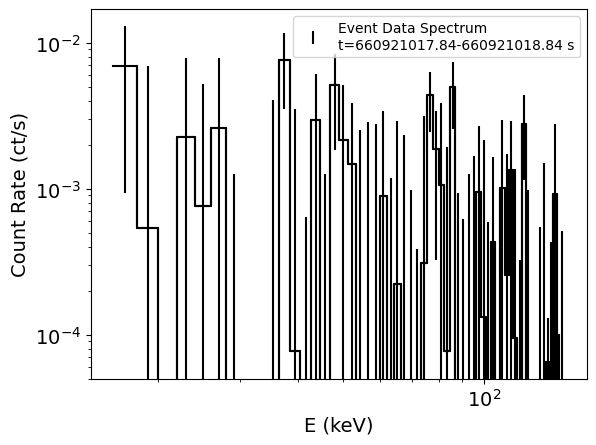

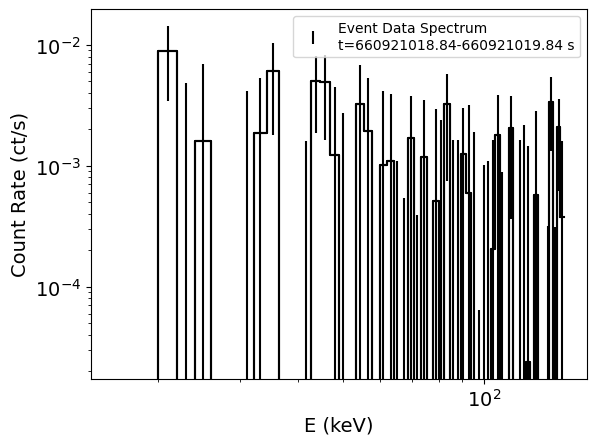

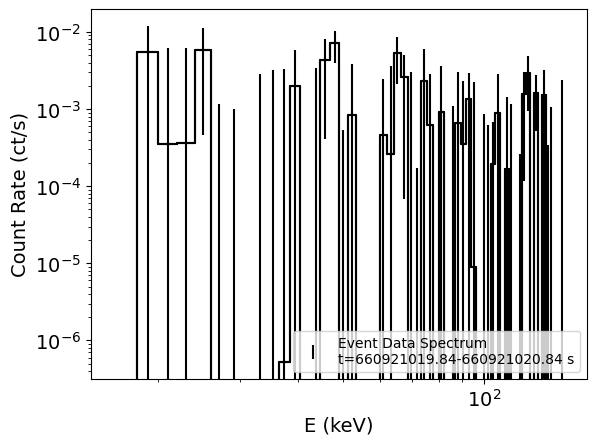

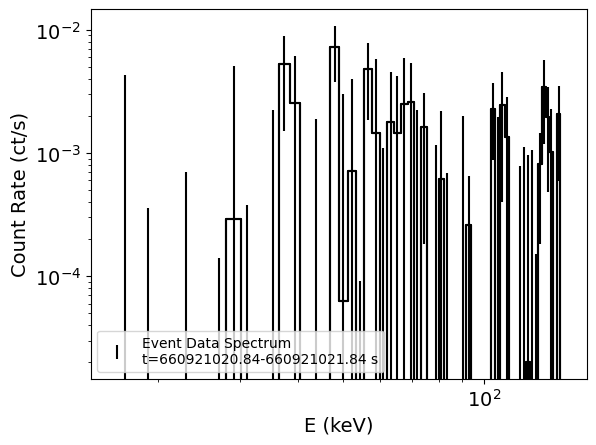

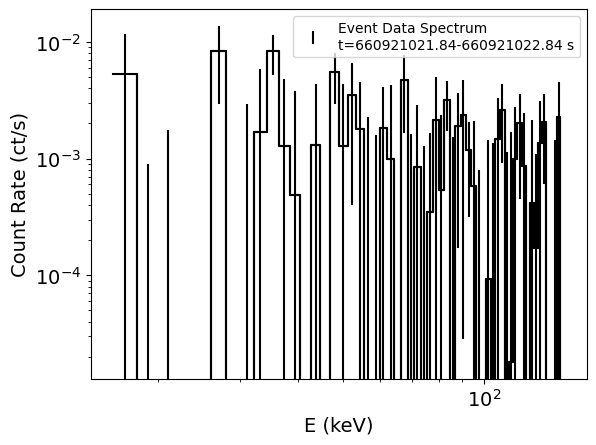

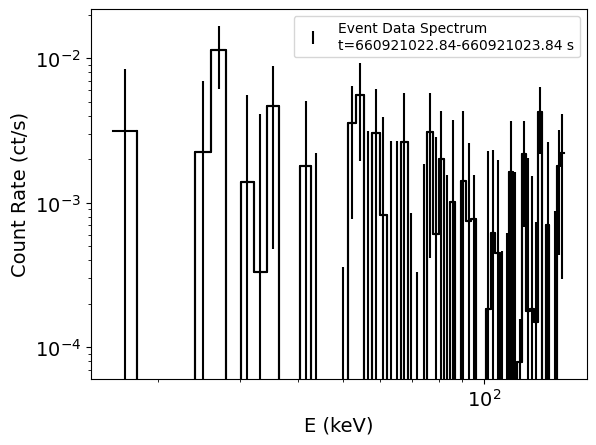

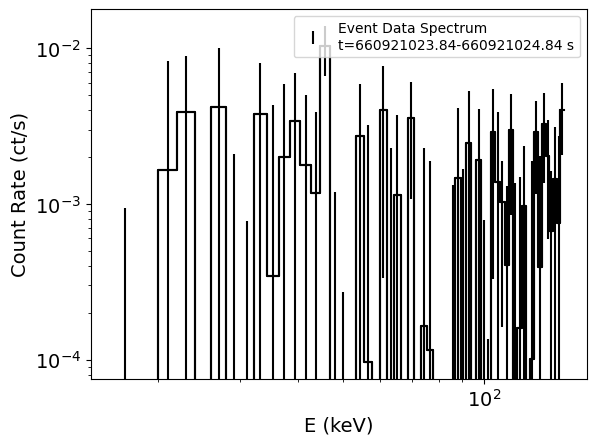

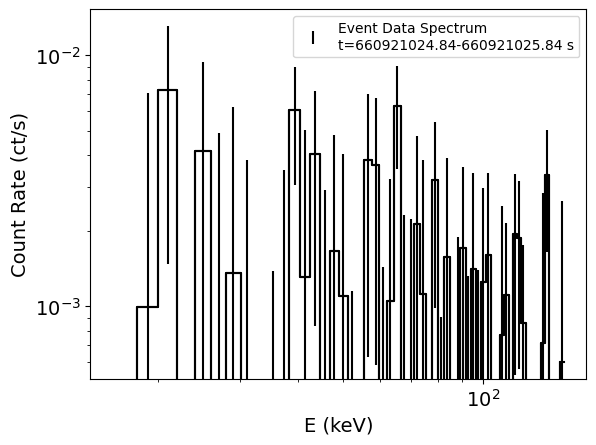

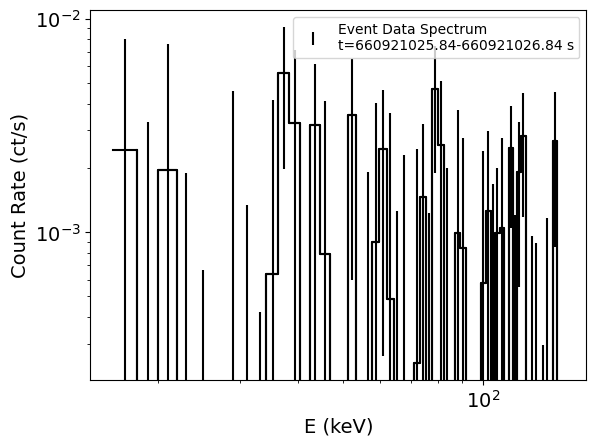

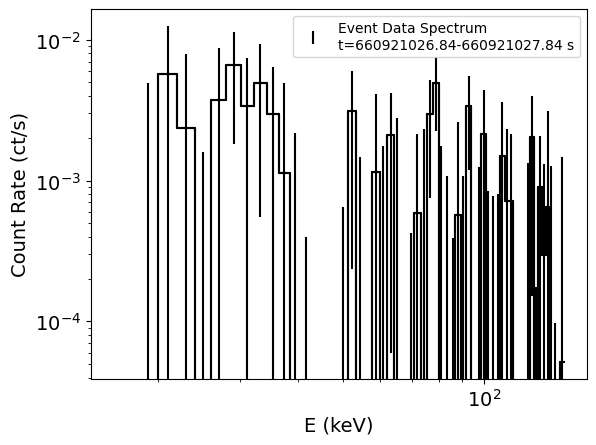

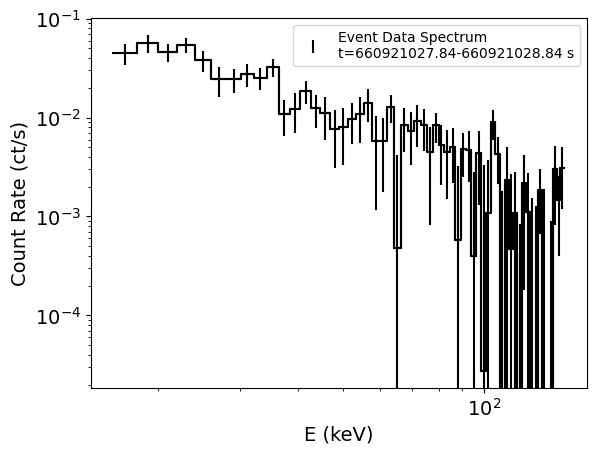

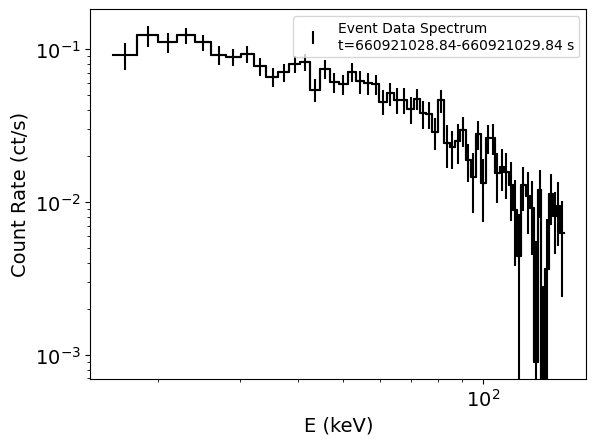

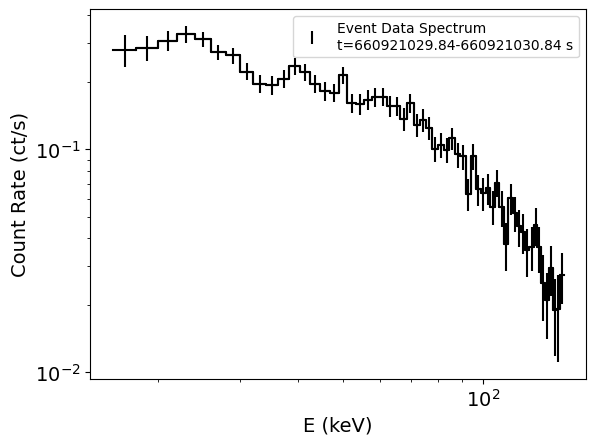

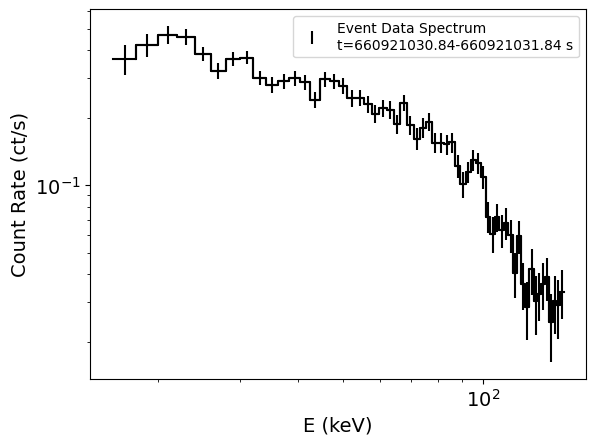

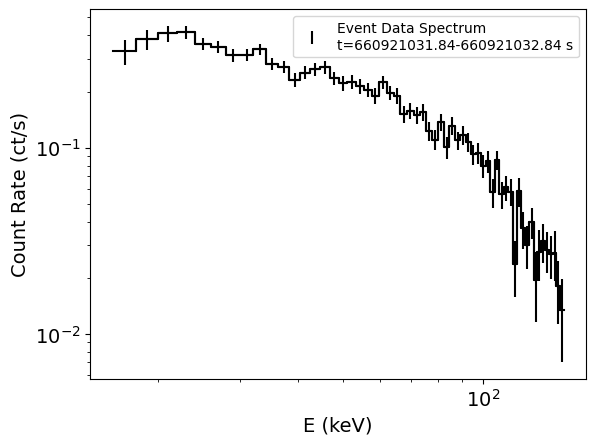

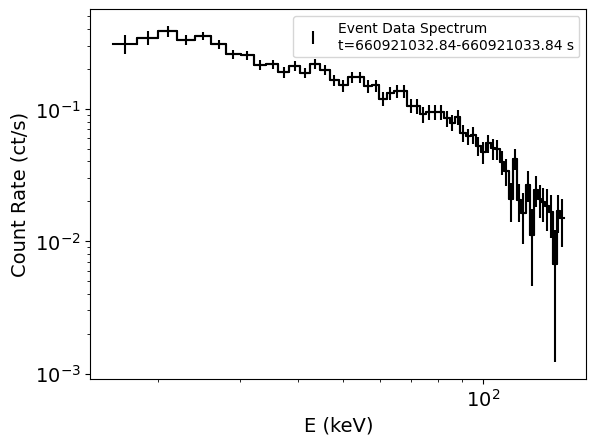

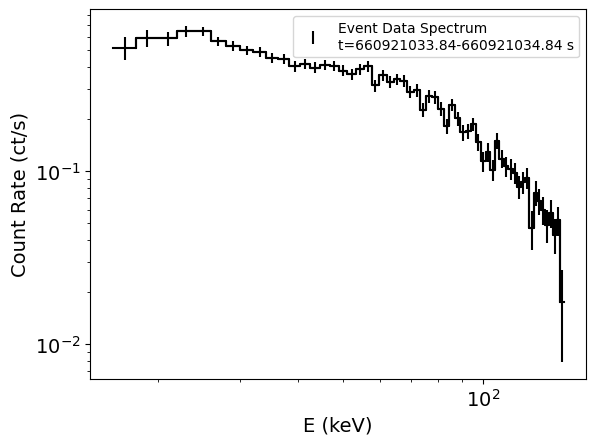

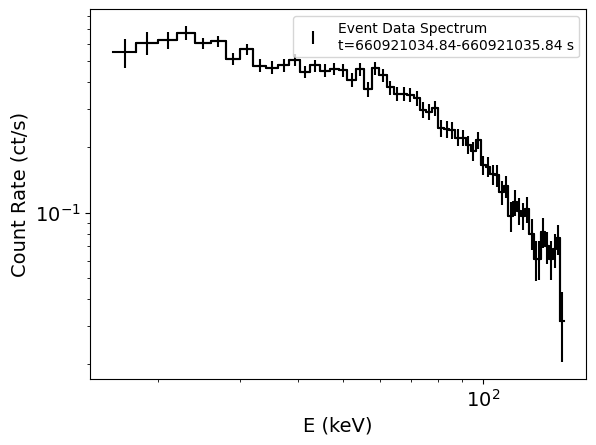

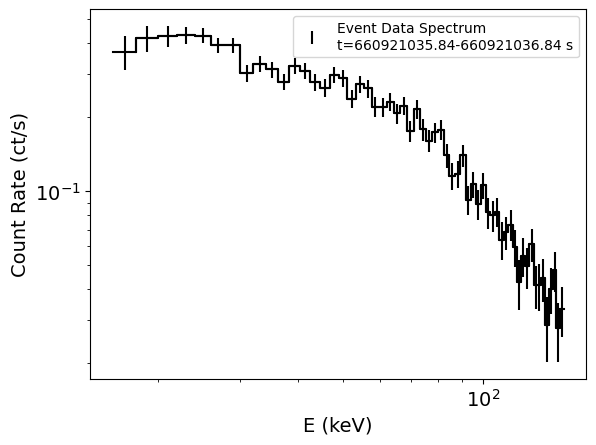

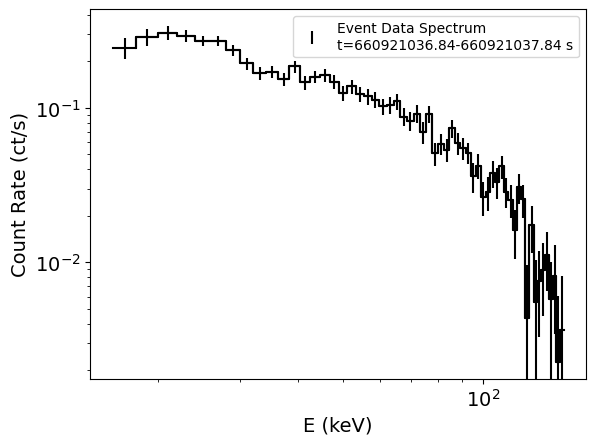

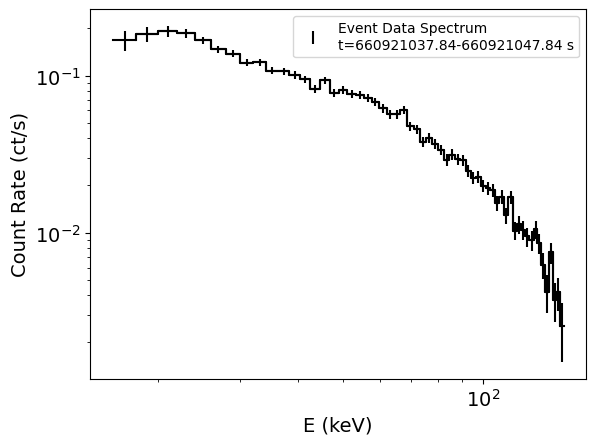

In [31]:
for i in spectrum_list:
    print(i.tbins["TIME_START"]-event.trigtime_met*u.s, i.tbins["TIME_STOP"]-event.trigtime_met*u.s)
    i.plot()

Next, we will fit all these spectra usng our batspectrum_analysis function. This function can fit multiple spectra and determine if the source has been significantly detected. If not, then it calculates the upper limit for us. We can do these operations in parallel by setting nprocs to a value that isnt 1 (and ideally not larger than the number of cores you have on your machine).

In [32]:
output_spectrum_list=ba.parallel.batspectrum_analysis(spectrum_list, recalc=True, nprocs=1) 


1 spectrum  in use
 
Spectral Data File: spectrum_0.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.358e-02 +/- 3.077e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_0.rsp for Source 1


Fit statistic  : C-Statistic                    0.28     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                  144.85     using 80 bins.
 Null hypothesis probability of 6.52e-06 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   po


***XSPEC Error:  No variable parameters for fit 
***XSPEC Error:  No variable parameters for fit 
***XSPEC Error:  No variable parameters for fit 
***XSPEC Error:  No variable parameters for fit 


1 spectrum  in use
 
Spectral Data File: spectrum_1.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  -4.035e-02 +/- 2.834e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_1.rsp for Source 1


Fit statistic  : C-Statistic                    1.65     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                 1662.97     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 6.51e-295 with 79 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV  


***XSPEC Error:  No variable parameters for fit 
***XSPEC Error:  No variable parameters for fit 
***XSPEC Error:  No variable parameters for fit 

    +/-  0.0          
   2    1   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : C-Statistic                    1.44     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                24248.72     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                   13.54     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44278.08     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 
The condition here is nan [nan, nan] 3 nan nan
No detection, just upperlimits for the spectrum: spectrum_2.pha

 N

Model Model Component  Parameter  UnitThe condition here is nan [nan, nan] 3 nan nan
No detection, just upperlimits for the spectrum: spectrum_3.pha
     Value
 par  comp
   1    1   powerlaw   PhoIndex            2.00000      frozen
   2    1   powerlaw   norm                126.806      +/-  145.409      
________________________________________________________________________


Fit statistic  : C-Statistic                    0.43     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                31353.46     using 58 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.00e+00 with 57 degrees of freedom

Parameters defined:
Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            2.00000      frozen
   2    1   powerlaw   norm                126.806      


***XSPEC Error:  No variable parameters for fit 

w   PhoIndex            2.00000      frozen
   2    1   powerlaw   norm                1.00000E-03  +/-  0.0          
________________________________________________________________________

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic  : C-Statistic                   12.89     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44278.06     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.00e+00 with 79 degrees of freedom
 Current data and model not fit yet.
     4 channels (1-4) ignored in spectrum #     1
    18 channels (63-80) ignored in spectrum #     1

Fit statistic  : C-Statistic                    9.85     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                34342.49     using 58 bi


***XSPEC Error:  No variable parameters for fit 

The condition here is nan [nan, nan] 3 nan nan
No detection, just upperlimits for the spectrum: spectrum_5.pha
             12.74     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44903.06     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 79 degrees of freedom
 Current data and model not fit yet.
     4 channels (1-4) ignored in spectrum #     1
    18 channels (63-80) ignored in spectrum #     1

Fit statistic  : C-Statistic                    9.58     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                34342.50     using 58 bins.
 Null hypothesis probability of 0.00e+00 with 57 degrees of freedom
 Current data and model not fit yet.


Fit statistic  : C-Statistic                    0.42     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                11209.14     using 58 bins.
 Null hypothesis probability 


***XSPEC Error:  No variable parameters for fit 
***XSPEC Error:  No variable pa

 for spectrum 1


Test statistic : Chi-Squared                11449.84     using 58 bins.
 Null hypothesis probability of 0.00e+00 with 57 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
C-Statistic  |beta|/N    Lvl        2:norm
0.482038     8.94467e-19  -3       131.860
 Variances and Principal Axes
                 2  
 2.1987E+04|  1.0000  
--------------------

  Covariance Matrix
        1   
   2.199e+04
------------

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            2.00000      frozen
   2    1   powerlaw   norm                131.860      +/-  148.279      
________________________________________________________________________


Fit statistic  : C-Statistic                    0.48     using 58 bins.

No detection, just upperlimits for the spectrum: spectrum_7.pha
stic is only valid for Poisson data.
    Source file is not Poi

rameters for fit 
***XSPEC Error:  No variable pa

The condition here is nan [nan, nan] 3 nan nan
No detection, just upperlimits for the spectrum: spectrum_8.pha
w   PhoIndex            2.00000      frozen
   2    1   powerlaw   norm                1.00000E-03  +/-  0.0          
________________________________________________________________________

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic  : C-Statistic                   13.10     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44278.08     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.00e+00 with 79 degrees of freedom
 Current data and model not fit yet.
     4 channels (1-4) ignored in spectrum #     1
    18 channels (63-80) ignored in spectrum #     1

Fit statistic  : C-Statistic                    9.83     using 58 bins.

    S

rameters for fit 
***XSPEC Error:  No variable par

w   PhoIndex            2.00000      frozen
   2    1   powerlaw   norm                1.00000E-03  +/-  0.0          
________________________________________________________________________

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic  : C-Statistic                   13.18     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44278.08     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.00e+00 with 79 degrees of freedom
 Current data and model not fit yet.
     4 channels (1-4) ignored in spectrum #     1
    18 channels (63-80) ignored in spectrum #     1

Fit statistic  : C-Statistic                    9.96     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                34342.51     using 58 bi

ameters for fit 

alue
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : C-Statistic                    1.27     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                23916.06     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                   12.67     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44278.07     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.00e+00 with

Fit statistic  : C-Statistic                   15.46     using 5The condition here is 1.8980768986531788e-06 [5.018253211170803e-07, 5.308817974718677e-06] 3 2.4034963268007985e-06 -5.312412081749216e-06
No detection, just upperlimits for the spectrum: spectrum_11.pha
8 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                34342.64     using 58 bins.
 Null hypothesis probability of 0.00e+00 with 57 degrees of freedom
 Current data and model not fit yet.


Fit statistic  : C-Statistic                    0.50     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                10579.37     using 58 bins.
 Null hypothesis probability of 0.00e+00 with 57 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
C-Statistic  |beta|/N    Lvl        2:norm
0.502732     6.50521e-19  -3       191.378
 Variances and Principal Axes
                 2  
 3.1911E+04|  


1 spectrum  in use
 
Spectral Data File: spectrum_12_bkgnsigma_5_upperlim.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.703e+00 +/- 1.734e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_12.rsp for Source 1


Fit statistic  : C-Statistic                    3.71     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                36557.94     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   powerlaw   norm                1.00000      +/-  0.0          
___________________________________________________


1 spectrum  in use
 
Spectral Data File: spectrum_13_bkgnsigma_5_upperlim.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.337e+00 +/- 1.925e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_13.rsp for Source 1


Fit statistic  : C-Statistic                    6.35     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                61659.40     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   powerlaw   norm                1.00000      +/-  0.0          
___________________________________________________


Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : C-Statistic                   18.79     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                40631.16     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                   76.15     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44903.38     using The condition here is 5.150979069352331e-06 [2.4397224316338905e-06, 9.825256003452073e-06] 3 3.6927667859090914e-06 -5.9273212883749435e-06
No detection, just upperlimits for the spectru

Fit statistic  : C-Statistic                   64.56     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44903.37     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 79 degrees of freedom
 Current data and model not fit yet.
     4 channels (1-4) ignored in spectrum #     1
    18 channels (63-80) ignored in spectrum #     1

Fit statistic  : C-Statistic                   53.38     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                34342.80     using 58 bins.
 Null hypothesis probability of 0.00e+00 with 57 degrees of freedom
 Current data and model not fit yet.


Fit statistic  : C-Statistic                    2.18     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared             The condition here is 1.2480582173840722e-05 [7.652129931944627e-06, 1.939346962128257e-05] 3 5.870669844668972e-06 -5.131427360166194e-0


1 spectrum  in use
 
Spectral Data File: spectrum_17_bkgnsigma_5_upperlim.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.167e+00 +/- 2.654e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_17.rsp for Source 1


Fit statistic  : C-Statistic                   12.94     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                122971.8     using 80 bins.
 Null hypothesis probability of 0.0e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   powerlaw   norm                1.00000      +/-  0.0          
____________________________________________________

 Current data and model not fit yet.
     4 channels (1-4) ignored in spectrum #     1
    18 channels (63-80) ignored in spectrum #     1

Fit statistic  : C-Statistic                  194.64     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                 5570.79     using 58 bins.
 Null hypothesis probability of 0.00e+00 with 56 degrees of freedom
 Current data and model not fit yet.


Fit statistic  : C-Statistic                  194.64     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                 5570.79     using 58 bins.
 Null hypothesis probability of 0.00e+00 with 56 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
C-Statistic  |beta|/N    Lvl    3:lg10Flux    4:PhoIndex
133.433      0.0615471     0      -7.44024       6.01601
123.073      10.4058       0      -7.26863       5.65761
106.149      11.2148      -1      -6.94817   

The condition here is 2.465299616121302e-07 [1.8895719511843255e-07, 5.851084069738377e-07] 3 1.980756059277026e-07 -3.476968561709775e-07
No detection, just upperlimits for the spectrum: spectrum_20.pha

1 spectrum  in use
 
Spectral Data File: spectrum_20_bkgnsigma_5_upperlim.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.625e-01 +/- 3.378e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 10 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_20.rsp for Source 1


Fit statistic  : C-Statistic                  101.16     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                484536.4     using 80 bins.
 Null hypothesis probability of 0.0e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  co

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


Lets plot the spectra that we obtained from the fits which will contain those that are upper limit created spectra

00      frozen
   2    1   powerlaw   norm                1.00000E-03  +/-  0.0          
________________________________________________________________________

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic  : C-Statistic                  145.61     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44903.06     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 79 degrees of freedom
 Current data and model not fit yet.
     4 channels (1-4) ignored in spectrum #     1
    18 channels (63-80) ignored in spectrum #     1

Fit statistic  : C-Statistic                  120.52     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                34342.50     using 58 bins.
 Null hypothesis probability of 0.00e+00 with 57 degrees of freedom
 Current data and model not fit yet.


Fit statistic  : C-Statistic 

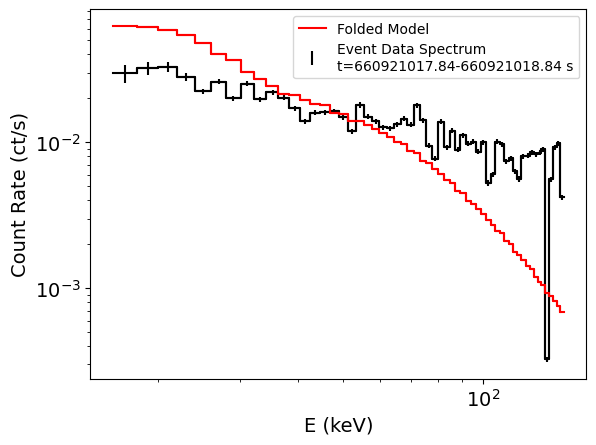

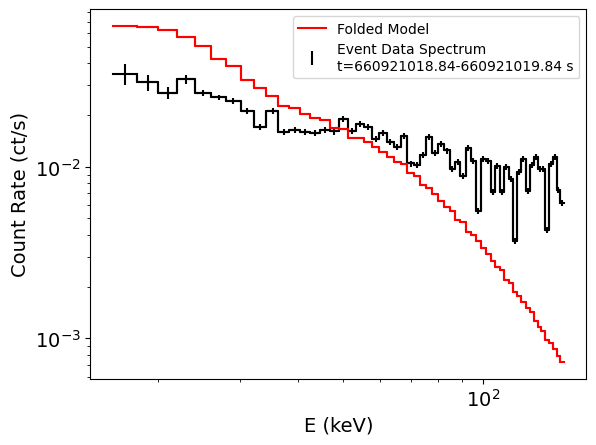

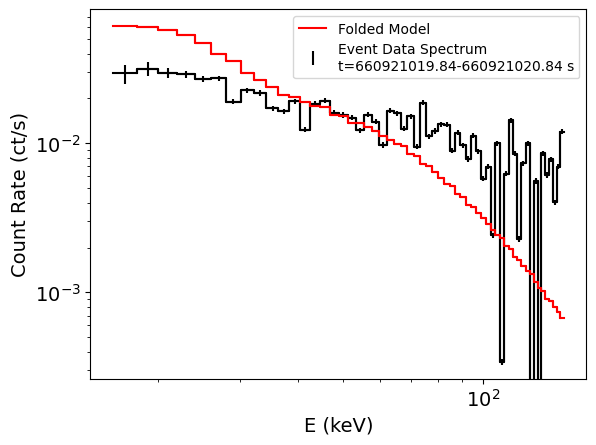

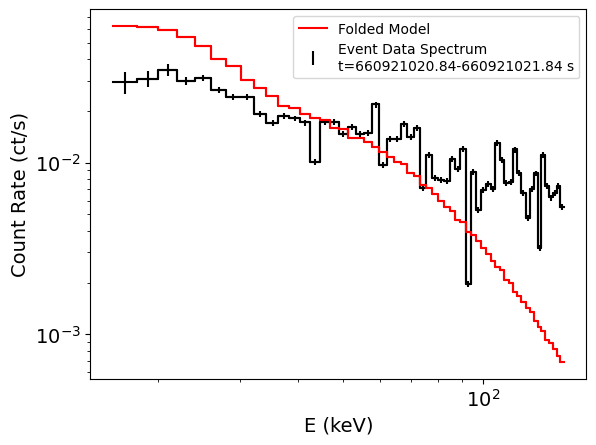

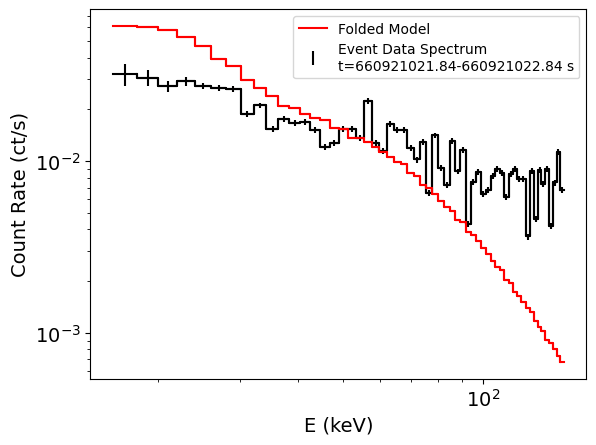

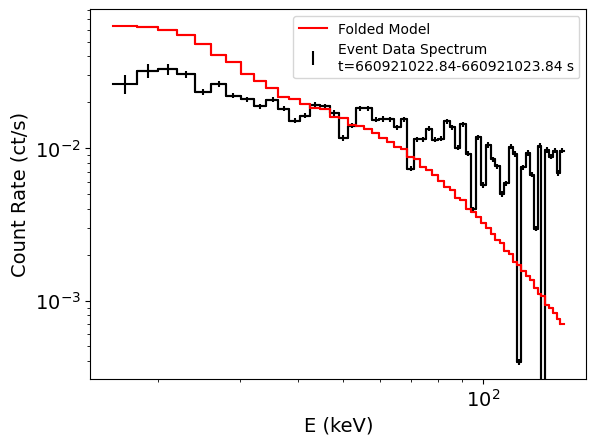

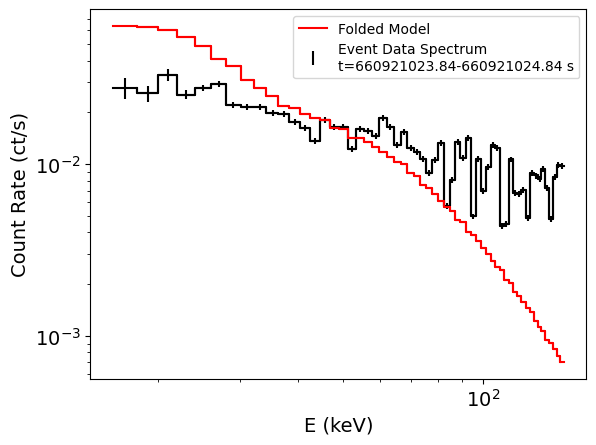

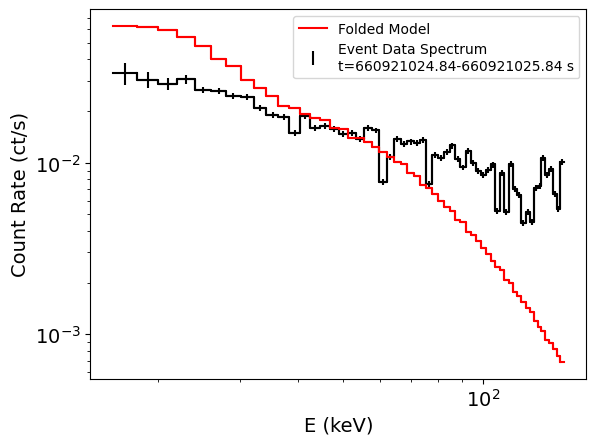

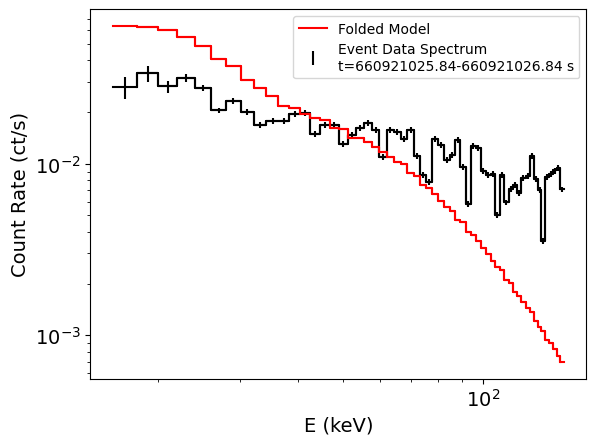

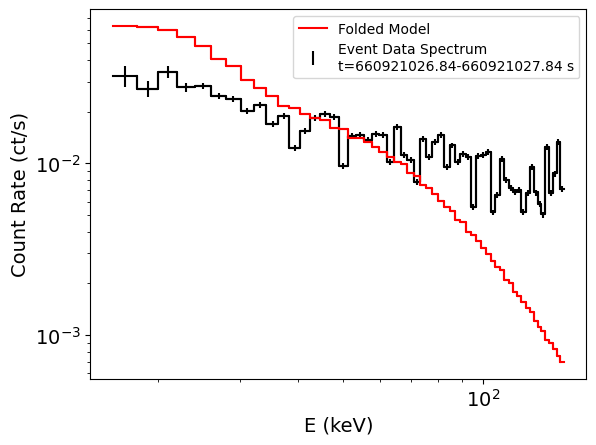

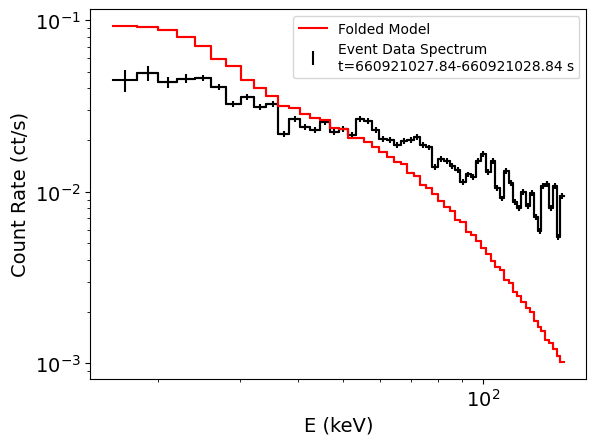

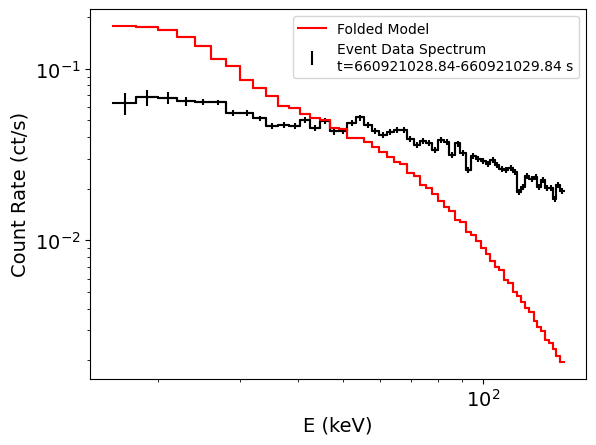

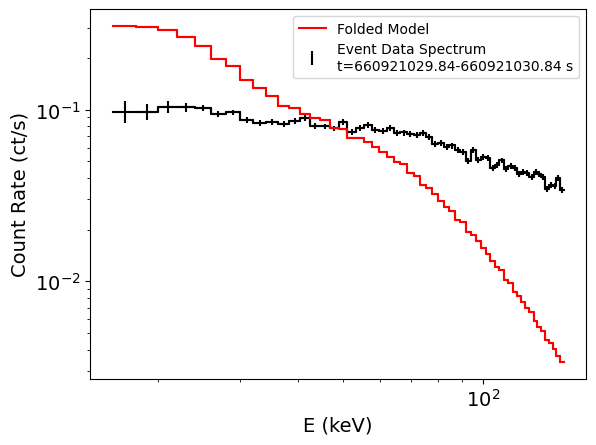

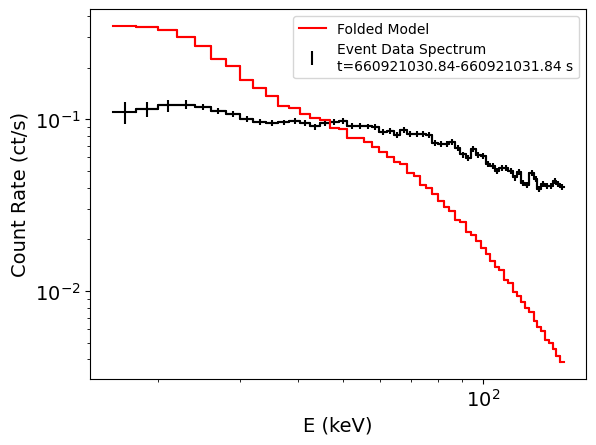

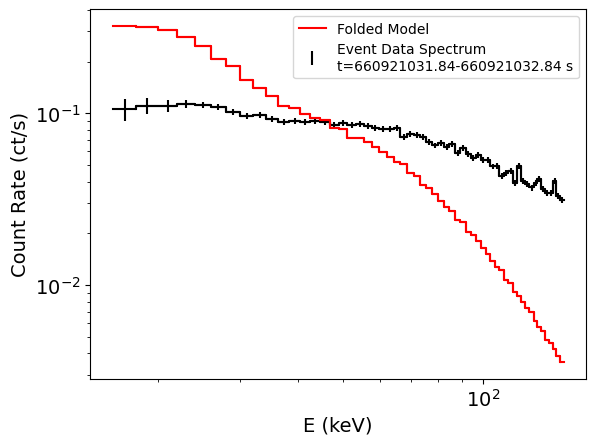

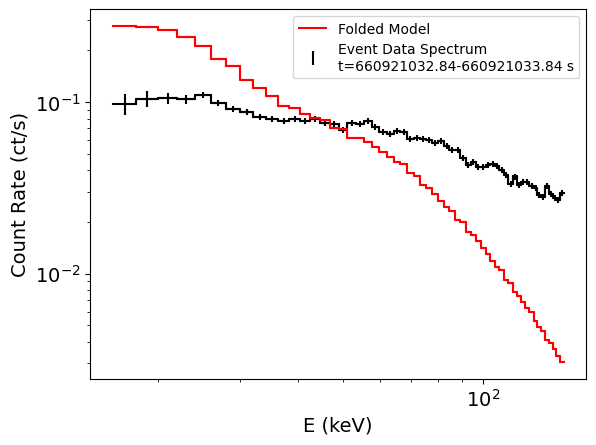

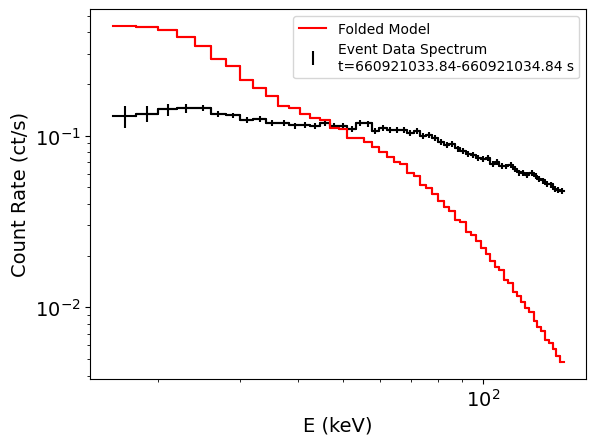

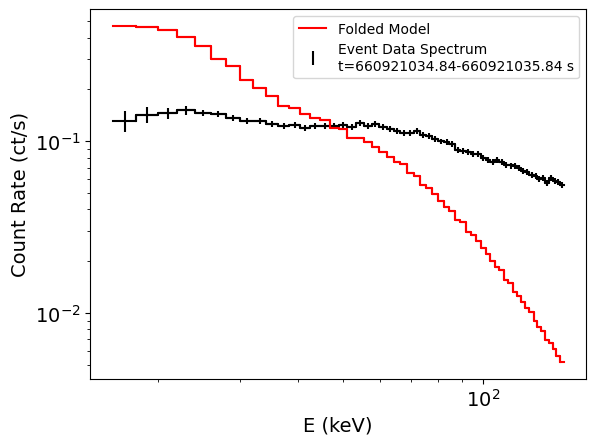

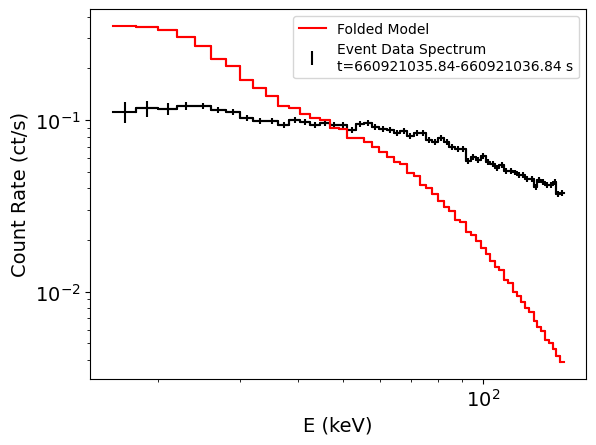

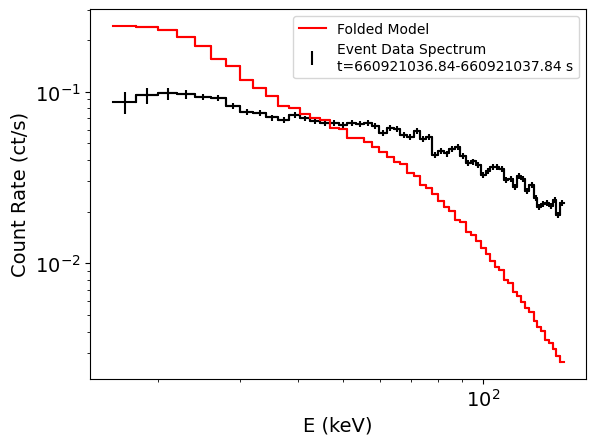

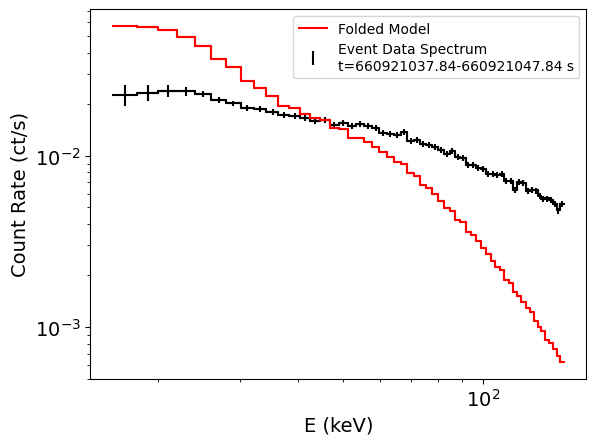

In [33]:
for i in output_spectrum_list:
    i.plot()

We can see that the spectral upper limit fits are not very good so we can try a differnet powerlaw index:


***XSPEC Error:  No variable parameters for fit 
***XSPEC Error:  No variable parameters for fit 
***XSPEC Error:  No variable parameters for fit 
***XSPEC Error:  No variable parameters for fit 


1 spectrum  in use
 
Spectral Data File: spectrum_0.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.358e-02 +/- 3.077e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_0.rsp for Source 1


Fit statistic  : C-Statistic                    1.38     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                 1364.65     using 80 bins.
 Null hypothesis probability of 1.96e-233 with 79 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   p


***XSPEC Error:  No variable parameters for fit 
***XSPEC Error:  No variable param

The condition here is nan [nan, nan] 3 nan nan
No detection, just upperlimits for the spectrum: spectrum_1.pha
             12.85     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44874.70     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 79 degrees of freedom
 Current data and model not fit yet.
     4 channels (1-4) ignored in spectrum #     1
    18 channels (63-80) ignored in spectrum #     1

Fit statistic  : C-Statistic                    9.86     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                34316.57     using 58 bins.
 Null hypothesis probability of 0.00e+00 with 57 degrees of freedom
 Current data and model not fit yet.


Fit statistic  : C-Statistic                    0.08     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                51075.02     using 58 bins.
 Null hypothesis probability 

eters for fit 
***XSPEC Error:  No variable parameters for fit 

red in spectrum #     1

Fit statistic  : C-Statistic                    0.53     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                   54.10     using 58 bins.
 Null hypothesis probability of 5.47e-01 with 56 degrees of freedom
 Current data and model not fit yet.


Fit statistic  : C-Statistic                    0.53     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                   54.10     using 58 bins.
 Null hypothesis probability of 5.47e-01 with 56 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
C-Statistic  |beta|/N    Lvl    3:lg10Flux    4:PhoIndex
***Warning: Negative alpha-matrix diagonal element for parameter 3
***Warning: Negative alpha-matrix diagonal element for parameter 4
 Parameter 3 is pegged at -12 due to zero or negative pivot element, likely
 caused by the fit being insensitive to the parameter.
 Paramete


1 spectrum  in use
 
Spectral Data File: spectrum_3_bkgnsigma_5_upperlim.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.013e+00 +/- 6.095e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_3.rsp for Source 1


Fit statistic  : C-Statistic                   12.89     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44278.34     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   power


***XSPEC Error:  No variable parameters for fit 


1 spectrum  in use
 
Spectral Data File: spectrum_4_bkgnsigma_5_upperlim.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.006e+00 +/- 6.210e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_4.rsp for Source 1


Fit statistic  : C-Statistic                   12.74     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44903.34     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   powerlaw   norm                1.00000      +/-  0.0          
_____________________________________________________


***XSPEC Error:  No variable parameters for fit 
***XSPEC Error:  No variable parameters for fit 


1 spectrum  in use
 
Spectral Data File: spectrum_6.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  -8.204e-04 +/- 3.024e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_6.rsp for Source 1


Fit statistic  : C-Statistic                    1.40     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                 1775.86     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 2.49e-318 with 79 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV  


***XSPEC Error:  No variable parameters for fit 

aw   PhoIndex            1.00000      frozen
   2    1   powerlaw   norm                1.00000E-03  +/-  0.0          
________________________________________________________________________

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic  : C-Statistic                   13.15     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44254.11     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.00e+00 with 79 degrees of freedom
 Current data and model not fit yet.
     4 channels (1-4) ignored in spectrum #     1
    18 channels (63-80) ignored in spectrum #     1

Fit statistic  : C-Statistic                   10.02     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                34320.23     using 58 b


***XSPEC Error:  No variable parameters for fit 
***XSPEC Error:  No variable parameters for fit 

t fit yet.

Fit statistic  : C-Statistic                     nan     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                     nan     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Current data and model not fit yet.

Fit statistic  : C-Statistic                    0.63     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                   76.79     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 4.85e-01 with 77 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                    0.63     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                   76.79     using 80 bins.

***Warning: Chi-square may not be valid du

   5    2   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : C-Statistic                     nan     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                     nan     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Current data and model not fit yet.

Fit statistic  : C-Statistic                     nan     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                     nan     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Current data and model not fit yet.

Fit statistic  : C-Statistic                    1.01     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                 


1 spectrum  in use
 
Spectral Data File: spectrum_10_bkgnsigma_5_upperlim.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.443e+00 +/- 7.423e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_10.rsp for Source 1


Fit statistic  : C-Statistic                    1.64     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                24448.67     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   pow

Test statistic : Chi-Squared                37293.64     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                   39.79     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44895.39     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 79 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      frozen
   2    1   powerlaw   norm                1.00000E-03  +/-  0.0          
________________________________________________________________________

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic  : C-Statistic      The condition here is 6.026078448163967e-06 [2.931968917563463e-06,

Net count rate (cts/s) for Spectrum:1  4.703e+00 +/- 1.734e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_12.rsp for Source 1


Fit statistic  : C-Statistic                    3.71     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                36557.94     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   powerlaw   norm                1.00000      +/-  0.0          
_______________________________________The condition here is 8.12041317744883e-06 [4.418564178264939e-06, 1.388152137832651e-05] 3 4.731478600

ins.
 Null hypothesis probability of 0.00e+00 with 77 degrees of freedom
 Current data and model not fit yet.
  parameter 4 is not frozen.

Fit statistic  : C-Statistic                  207.13     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                 5455.94     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 77 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                  207.13     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                 5455.94     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.
Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic  : C-Statistic                  207.13     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared        

Test statistic : Chi-Squared                 4992.48     using 58 bins.
 Null hypothesis probability of 0.00e+00 with 56 degrees of freedom
 Current data and model not fit yet.


Fit statistic  : C-Statistic                  166.18     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                 4992.48     using 58 bins.
 Null hypothesis probability of 0.00e+00 with 56 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
C-Statistic  |beta|/N    Lvl    3:lg10Flux    4:PhoIndex
113.76       0.0551321     0      -7.50828       6.08480
104.883      8.89465       0      -7.33613       5.71272
90.3469      9.58465      -1      -7.01514       5.40954
74.1441      10.287       -2      -6.63738       5.25272
58.3161      10.4799      -3      -6.28074       5.08151
44.1573      10.061       -4      -5.99699       4.78896
32.1353      8.99806      -5      -5.83111       4.28029
21.6712      7.83363 


1 spectrum  in use
 
Spectral Data File: spectrum_16_bkgnsigma_5_upperlim.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.643e+00 +/- 2.377e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_16.rsp for Source 1


Fit statistic  : C-Statistic                   11.54     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                109687.1     using 80 bins.
 Null hypothesis probability of 0.0e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   powerlaw   norm                1.00000      +/-  0.0          
____________________________________________________

0.134972     1.78254     -15      -4.85047       1.02132
0.133813     0.154504    -16      -4.84655       1.01648
 Variances and Principal Axes
                 3        4  
 1.0557E-02|  0.9912   0.1324  
 1.7758E-01| -0.1324   0.9912  
------------------------------

  Covariance Matrix
        1           2   
   1.349e-02  -2.192e-02
  -2.192e-02   1.746e-01
------------------------

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      15.0000      frozen
   2    1   cflux      Emax       keV      150.000      frozen
   3    1   cflux      lg10Flux   cgs      -4.84655     +/-  0.116128     
   4    2   powerlaw   PhoIndex            1.01648      +/-  0.417909     
   5    2   powerlaw   norm                1.00000E-03  frozen
______________________________________The condition here is 8.447528095097566e-06 [4.6410332656472644e-06, 1.4325653255529864e-05] 3 4.8423099949413e-06 -6.0


1 spectrum  in use
 
Spectral Data File: spectrum_19_bkgnsigma_5_upperlim.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.612e+00 +/- 1.291e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            spectrum_19.rsp for Source 1


Fit statistic  : C-Statistic                    2.94     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                28038.41     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   powerlaw   norm                1.00000      +/-  0.0          
___________________________________________________

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


  Covariance Matrix
        1           2   
   7.902e+00   4.497e+00
   4.497e+00   2.561e+00
------------------------

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      15.0000      frozen
   2    1   cflux      Emax       keV      150.000      frozen
   3    1   cflux      lg10Flux   cgs      -6.99250     +/-  2.81108      
   4    2   powerlaw   PhoIndex            -2.73378     +/-  1.60033      
   5    2   powerlaw   norm                1.00000E-03  frozen
________________________________________________________________________


Fit statistic  : C-Statistic                    7.00     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                 3464.66     using 58 bins.
 Null hypothesis probability of 0.00e+00 with 56 degrees of freedom
                                   Parameters
C-Statistic  |beta|/N    Lvl    3:lg10Flux   

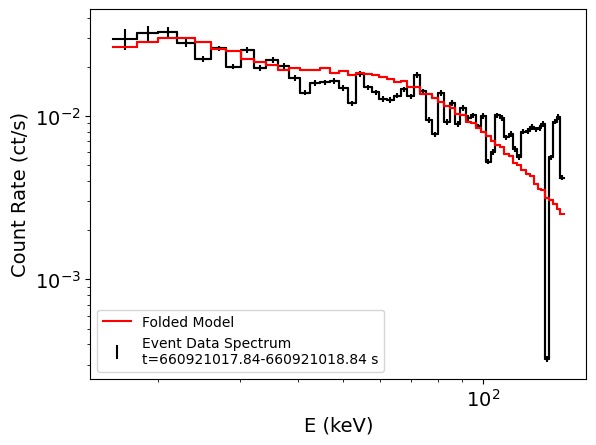

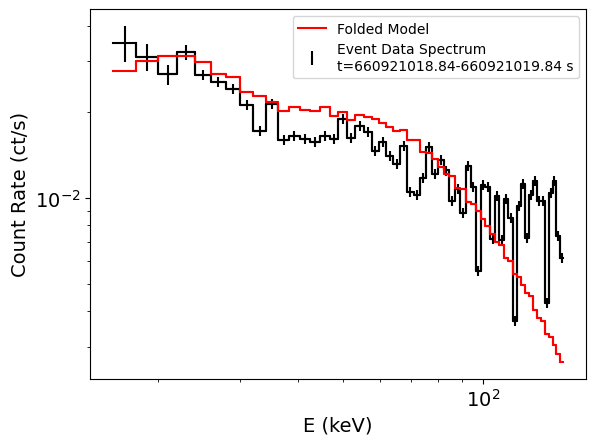

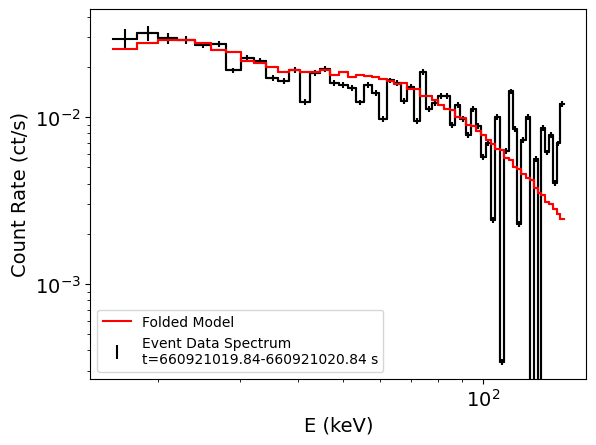

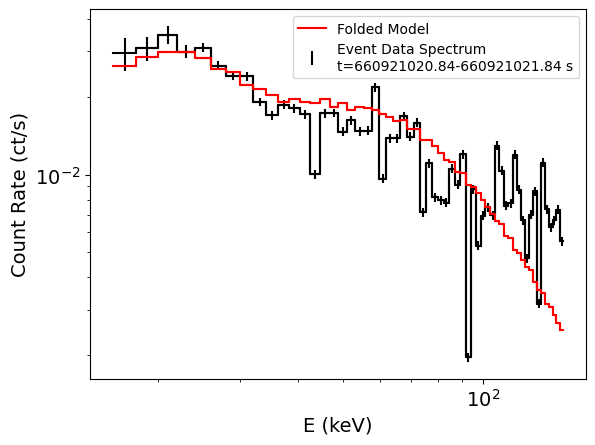

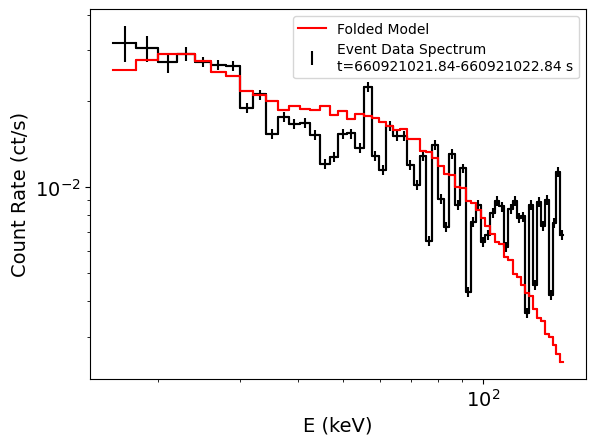

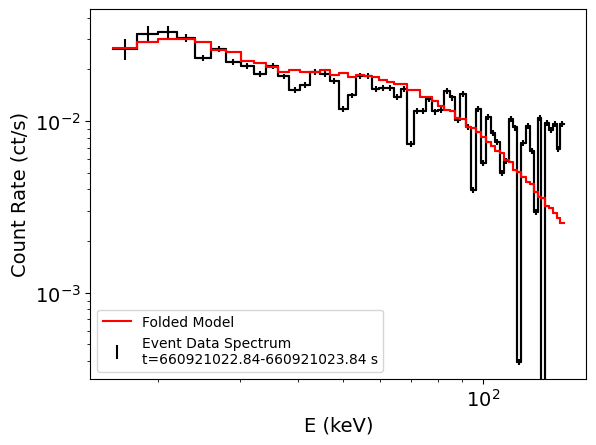

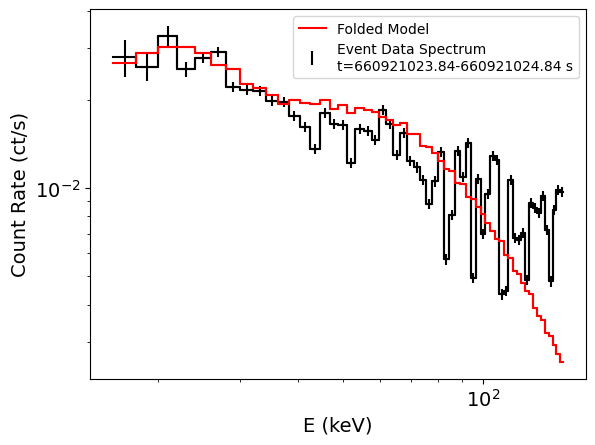

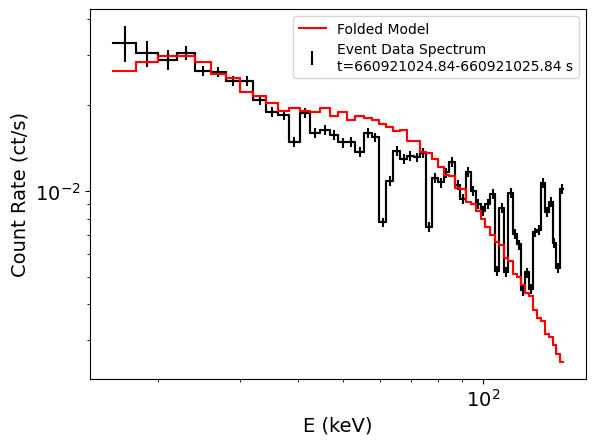

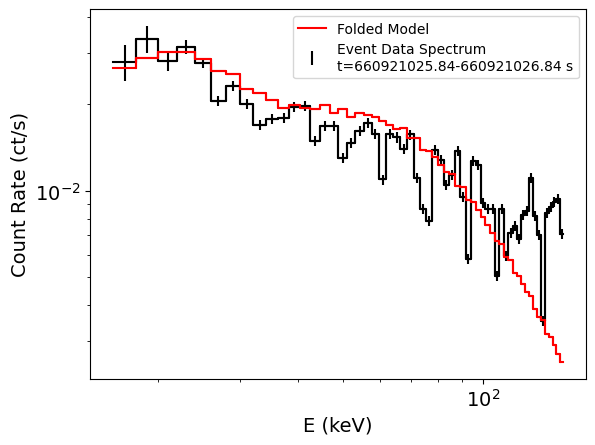

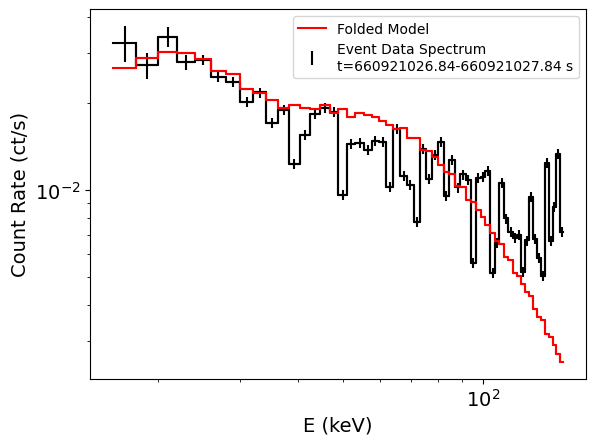

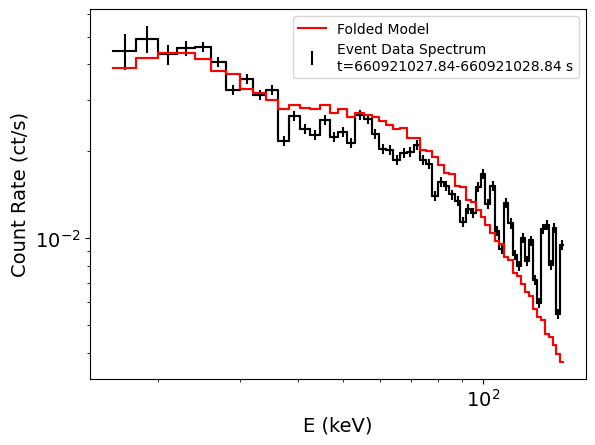

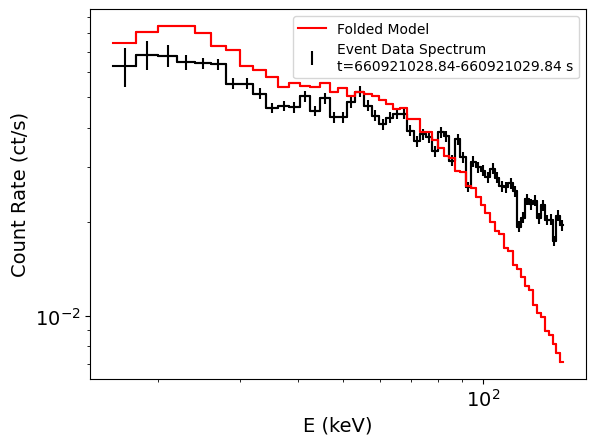

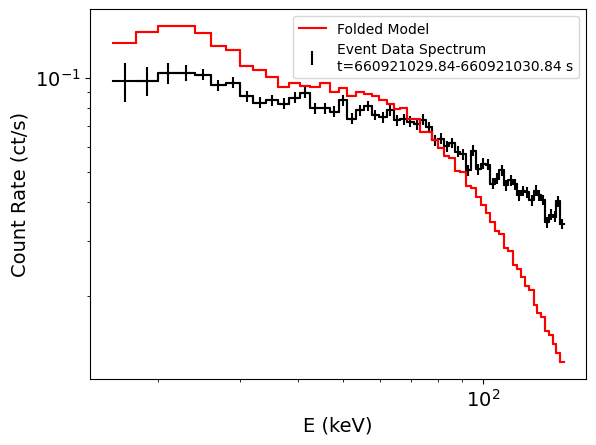

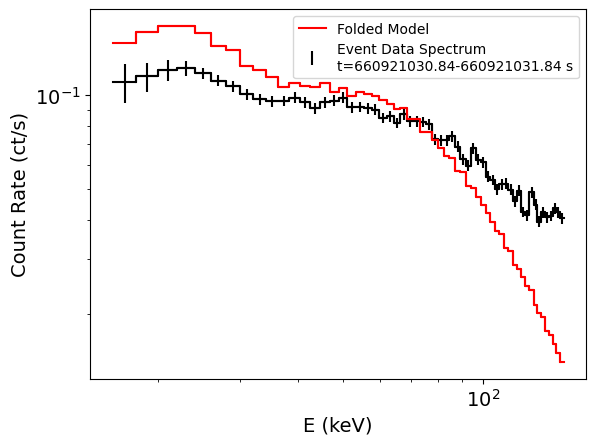

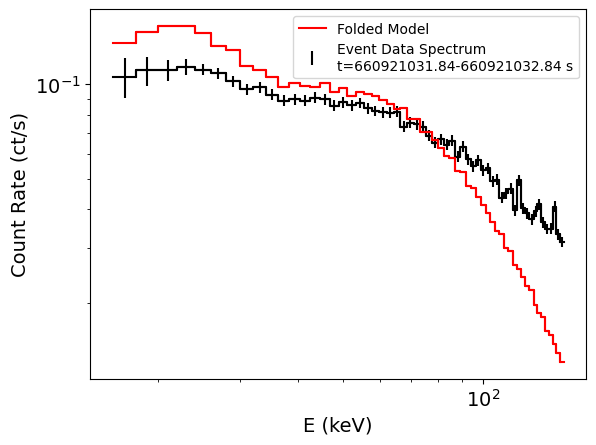

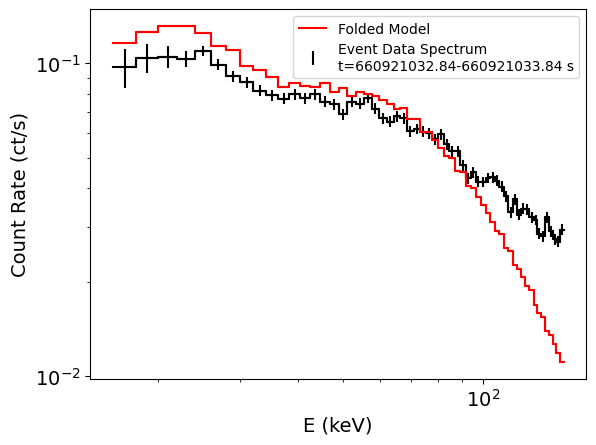

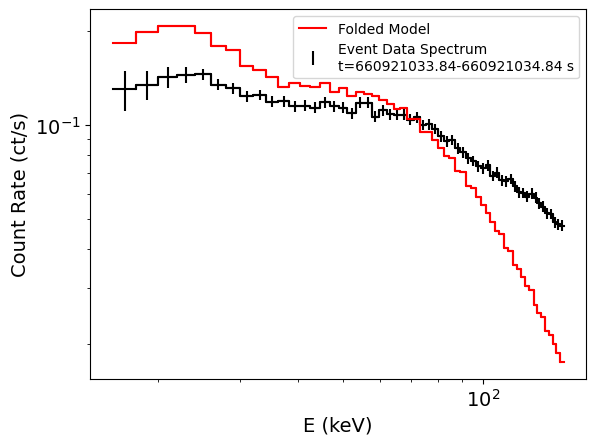

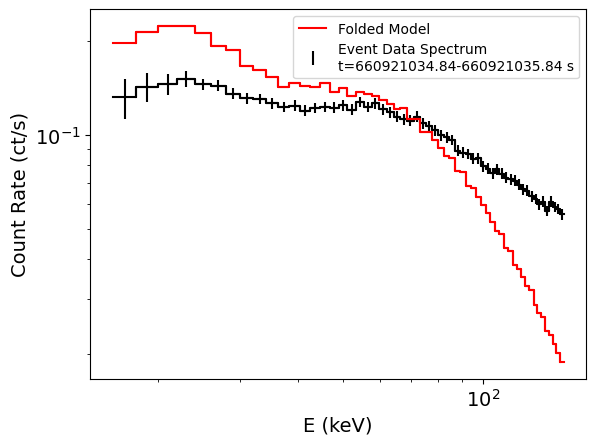

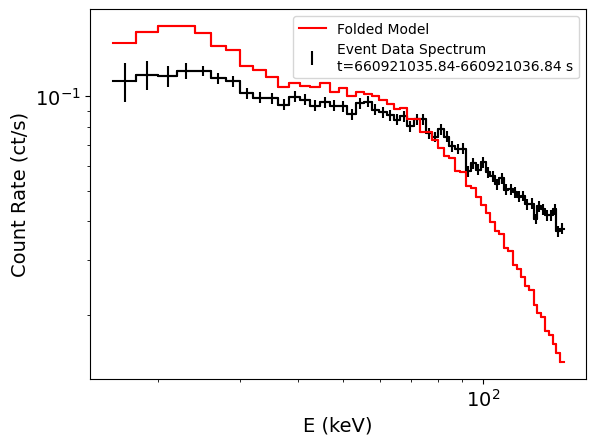

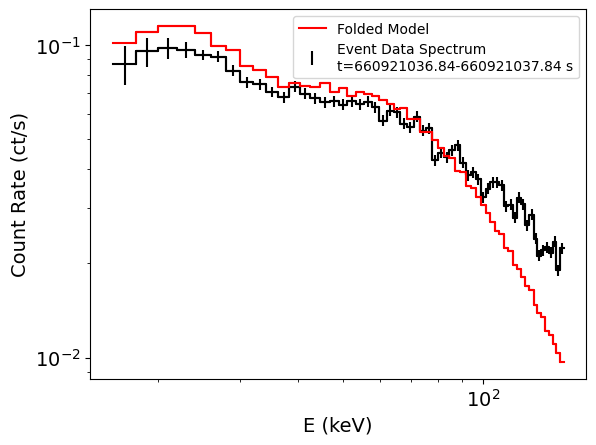

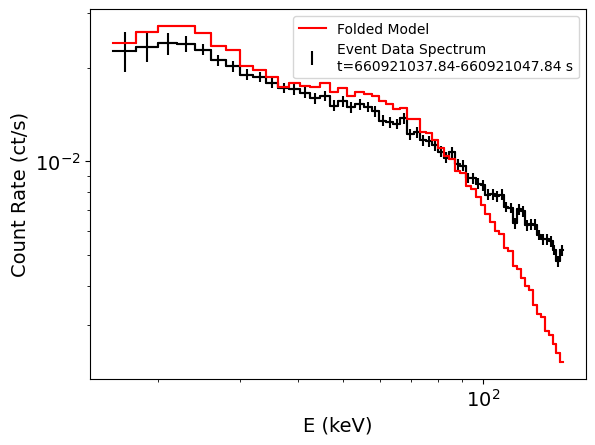

In [34]:
output_spectrum_list=ba.parallel.batspectrum_analysis(spectrum_list, ul_pl_index=1, recalc=True) 
for i in output_spectrum_list:
    i.plot()

Lets not plot our lightcurve and the spectral parameters. We will see any flux upper limits as fluxes with downward pointing arrows, for time bins where the source was not detected at the 3$\sigma$ level and the photon index that we had specified without any errorbars. In the second plot, we show the original spectra as they were fit and the errors associated with the fits, regardless of how well the GRB was detected. We also exhibit how we can conveniently modify the plot axis/labels after the function has been called. 

Text(0, 0.5, '50-150 keV flux')

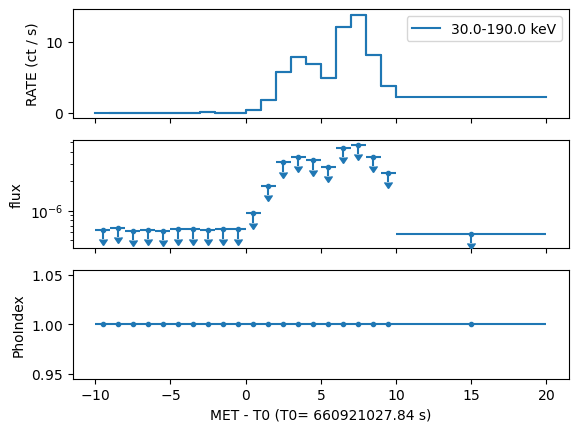

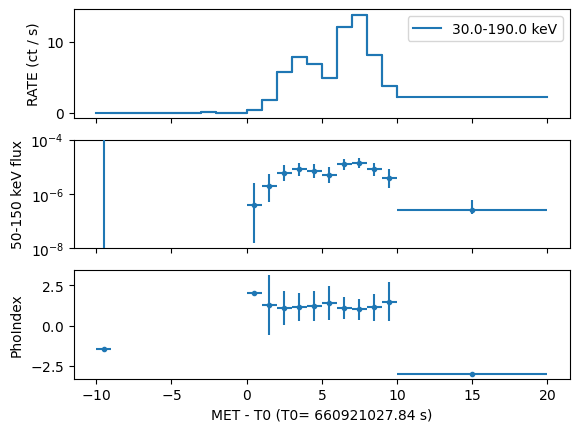

In [41]:
ba.plot_TTE_lightcurve(event.lightcurve, output_spectrum_list, energy_range=None, T0=event.trigtime_met, plot_relative=True)


fig, ax=ba.plot_TTE_lightcurve(event.lightcurve, spectrum_list, energy_range=None, T0=event.trigtime_met, plot_relative=True)
ax[1].set_ylim([10**-8, 10**-4])
ax[1].set_ylabel("50-150 keV flux")

### Additional Verification of the Code Base

here, we will compare the reference GRB catalog data to the results of the BatAnalysis code. We will download the relevant files from here: https://swift.gsfc.nasa.gov/results/batgrbcat/GRB211211A/data_product/remake_spec/spec_time_resolved/ and produce spectra with BatAnalysis using the same parameters. We will plot and fit these to verify the codebase and show that we produce identical results.

In [48]:
import requests
from bs4 import BeautifulSoup

base_url="https://swift.gsfc.nasa.gov/results/batgrbcat/GRB211211A/data_product/remake_spec/spec_time_resolved/"
site=requests.get(base_url)
print(site)

AttributeError: 'Response' object has no attribute 'p'

In [ ]:
#test_spect=event.create_pha(timebins=[660921027.868,660921027.952]*u.s, recalc=True)

In [ ]:
# grbcat_spect=ba.Spectrum.from_file("/Users/tparsota/Downloads/sw01088940000b_avg.pha")

In [ ]:
#fig,ax=test_spect.plot(emin=15*u.keV, emax=150*u.keV)
# fig,ax=grbcat_spect.plot(emin=15*u.keV, emax=150*u.keV)

In [ ]:
#output_test_spectra=ba.parallel.batspectrum_analysis([test_spect, grbcat_spect])

In [ ]:
# fig,ax=test_spect.plot(emin=15*u.keV, emax=150*u.keV)
# fig,ax=grbcat_spect.plot(emin=15*u.keV, emax=150*u.keV)
# print(test_spect.spectral_model["parameters"])
# print(grbcat_spect.spectral_model["parameters"])

/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/batproducts.py:2007: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


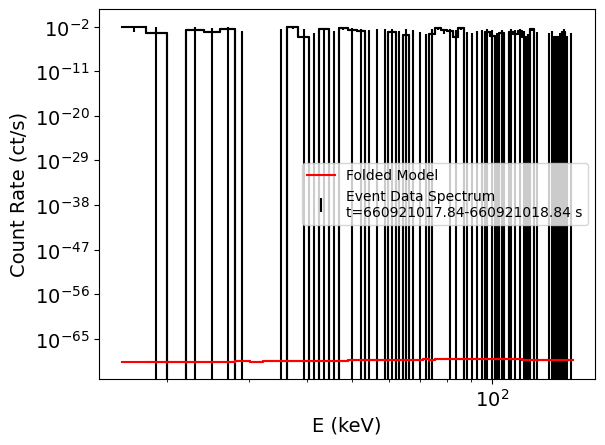

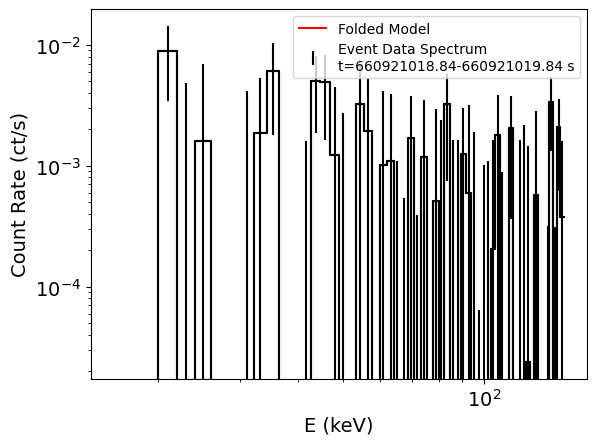

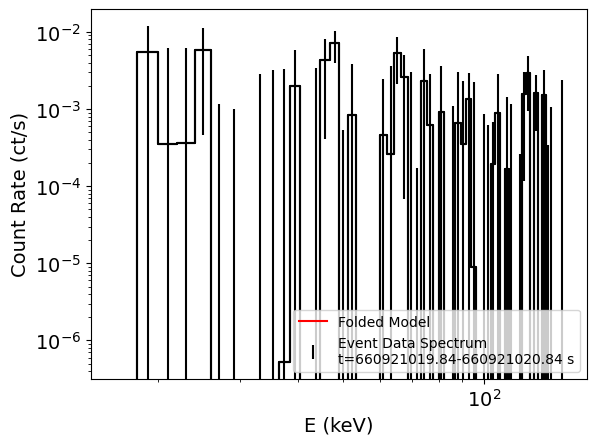

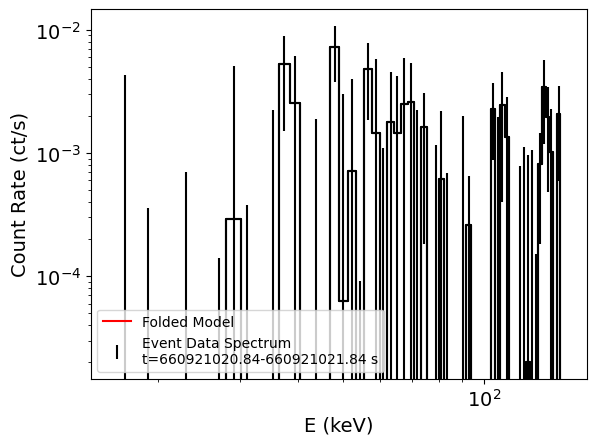

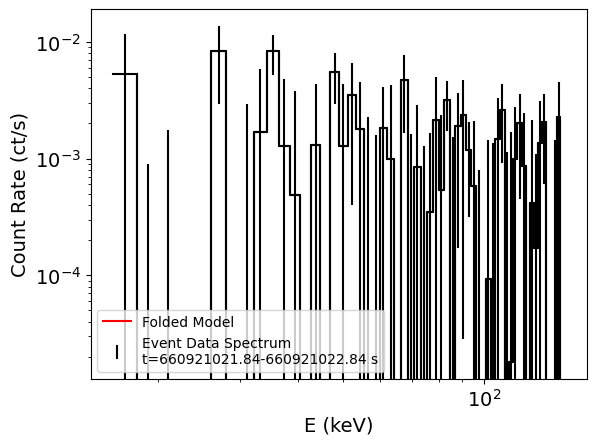

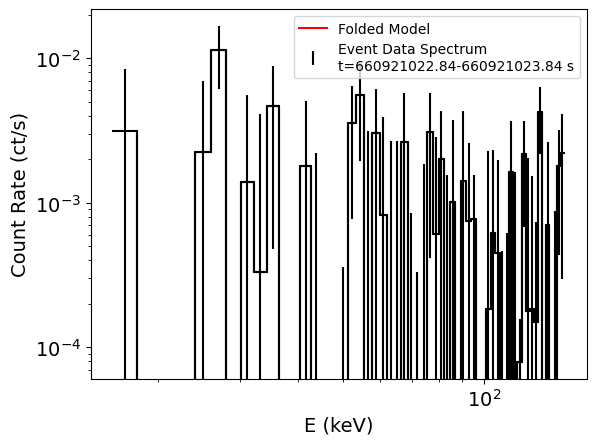

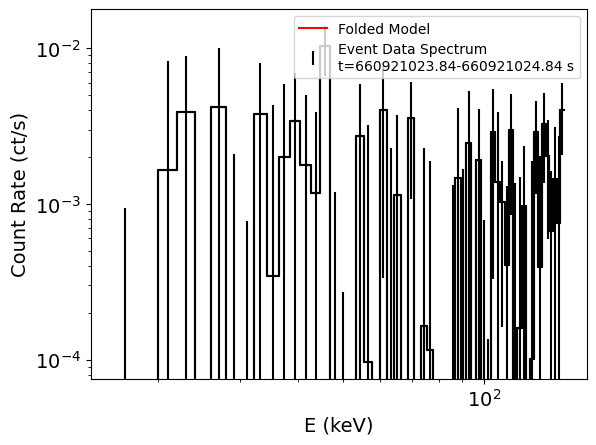

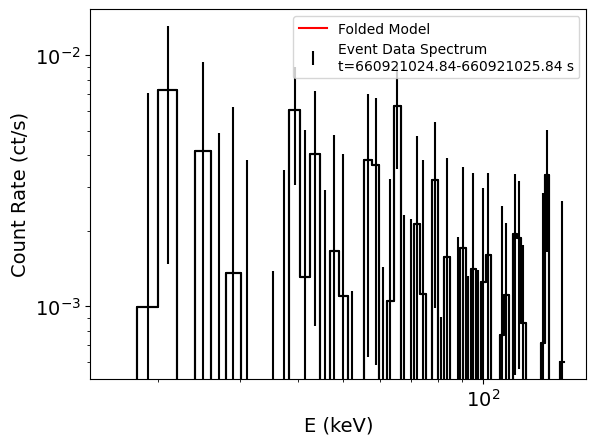

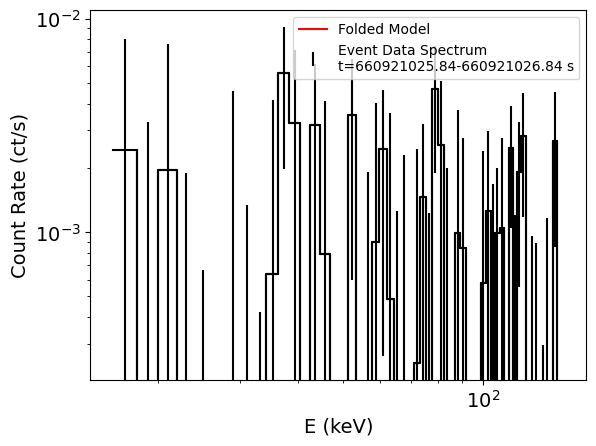

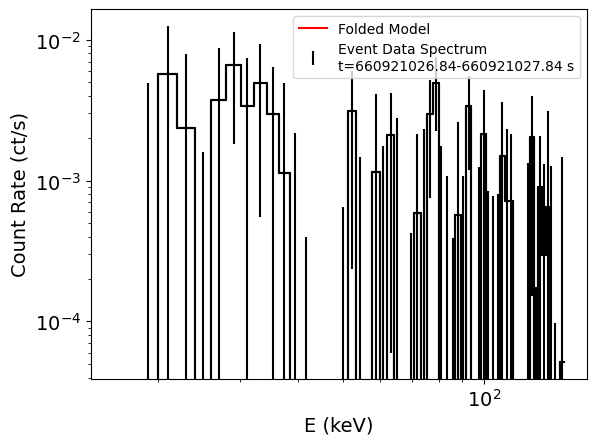

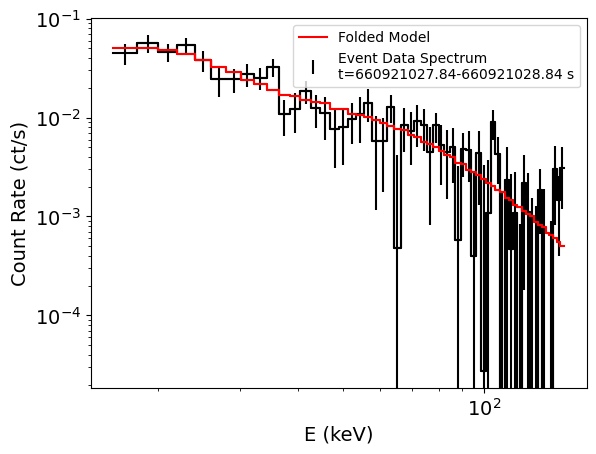

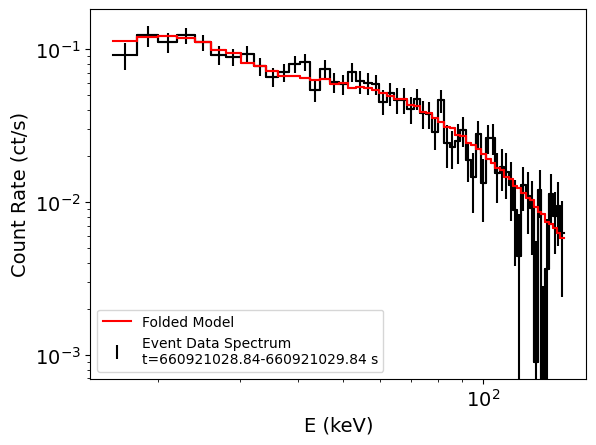

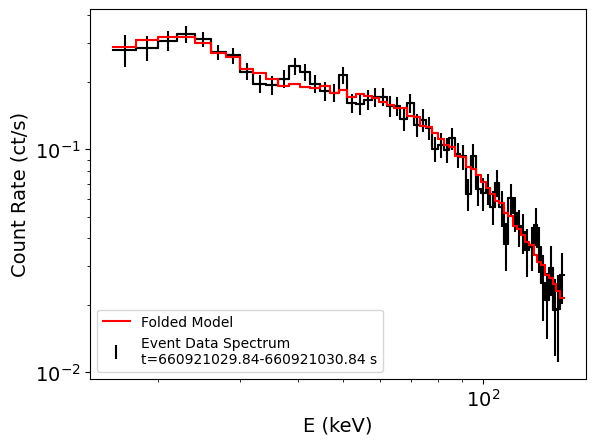

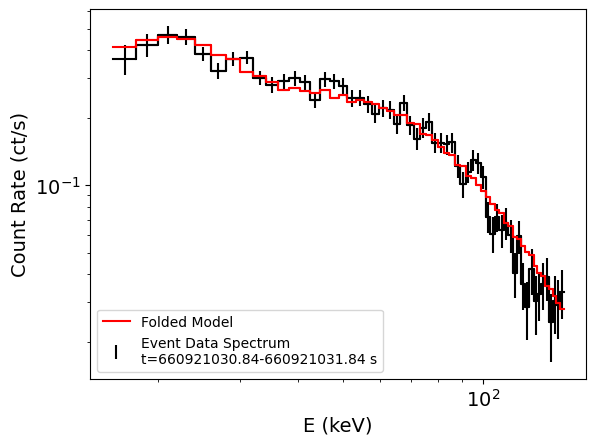

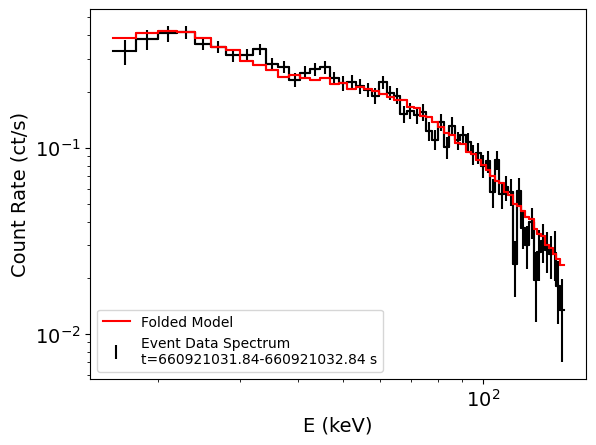

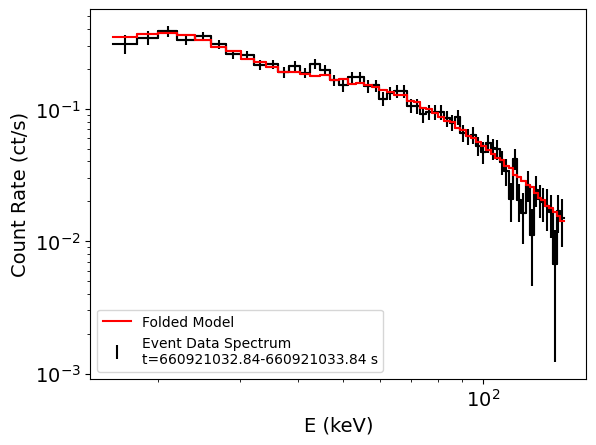

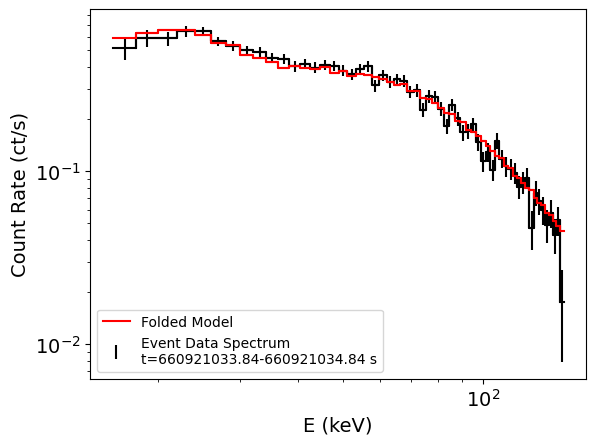

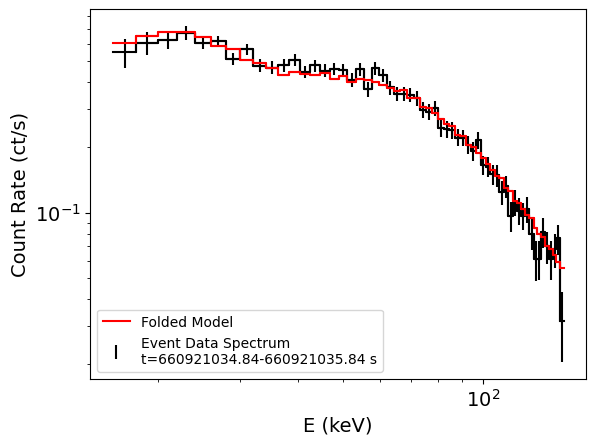

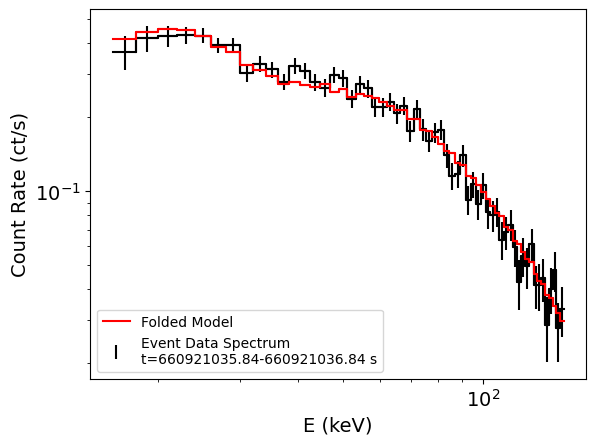

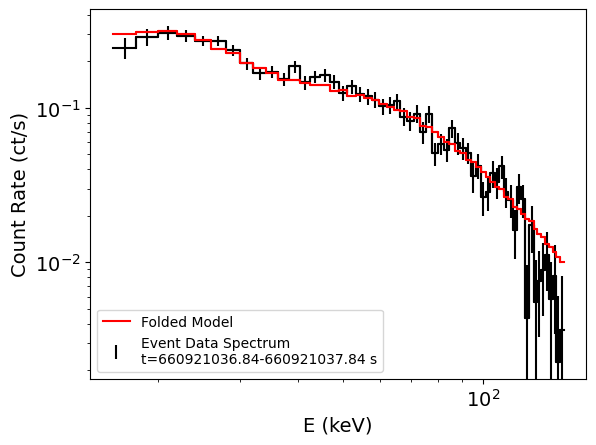

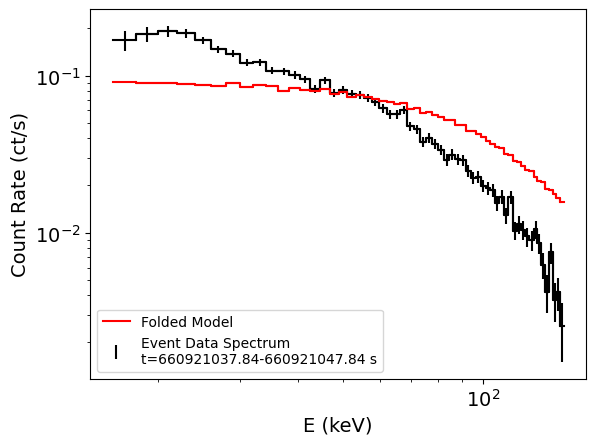

In [37]:
for i in spectrum_list:
    i.plot()